In [0]:
import torch
import os
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.autograd import Variable
from collections import defaultdict
from torchvision.utils import save_image
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt
import numpy as np

import copy 
from prettytable import PrettyTable

In [0]:
#Mount Google Drive for loading and storing model's weights
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def setSeed(manualSeed):
	np.random.seed(manualSeed)
	torch.manual_seed(manualSeed)
	torch.cuda.manual_seed(manualSeed)
	torch.cuda.manual_seed_all(manualSeed)

	torch.backends.cudnn.enabled = False
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True

setSeed(2)

In [0]:
hparams = {
    'batch_size':128,
    'num_epochs':20,
    'num_classes':10,
    'pixels_inputs':784,
    'learning_rate':1e-3
}

hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

#1. Load MNIST train and test sets. 

Split the original training data into 95% training and 5% validation data

In [0]:
percentage_train=0.95

mnist_trainset = MNIST('data', train=True, download=True,
                              transform=transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,)) #normalize to [-1, 1] since these are the mean and std deviation of the MNIST dataset
                              ]))
mnist_testset = MNIST('data', train=False, 
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.1307,), (0.3081,)) # the mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values:
                             ]))

train_size = int(percentage_train * len(mnist_trainset))
val_size = len(mnist_trainset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(mnist_trainset, [train_size, val_size])

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=hparams['batch_size'],
    shuffle=True)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=hparams['batch_size'], 
    shuffle=False)

test_loader = torch.utils.data.DataLoader(
    mnist_testset,
    batch_size=hparams['batch_size'], 
    shuffle=False)


  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20085043.91it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


32768it [00:00, 315397.68it/s]                           
0it [00:00, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


1654784it [00:00, 5240466.06it/s]                           
8192it [00:00, 126207.03it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


In [0]:
#Checkings
images, _ = iter(train_loader).next()
print('images shape on batch size = {}'.format(images.size()))
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

images shape on batch size = torch.Size([128, 1, 28, 28])
57000
3000
10000


#2. Implement a convolutional autoencoder 

(with separate Encoder and Decoder modules)

In [0]:
class Encoder(nn.Module):
    def __init__(self, bottleneck):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=3, padding=1),  # b, 8, 10, 10
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=3, padding=1),  # b, 16, 4, 4
            nn.ReLU(True))
        
        self.inn = nn.Sequential(
              nn.Linear(16*4*4, bottleneck),
              nn.ReLU())

    def forward(self, x):
        x = self.encoder(x)
        x= x.view(x.shape[0], -1)
        return self.inn(x)

In [0]:
class Decoder(nn.Module):
    def __init__(self, bottleneck):
        super(Decoder, self).__init__()
        
        self.out = nn.Sequential(
              nn.Linear(bottleneck, 16*4*4),
              nn.ReLU())
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=3, padding=1),  # b, 8, 10, 10
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=3, padding=1),  # b, 1, 28, 28
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.out(x)
        x = x.view(x.shape[0], 16, 4, 4)
        x = self.decoder(x)
        return x

In [0]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self, bottleneck):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.bottleneck = bottleneck
        # Necessari per l'autoencoder:
        self.encoder = Encoder(bottleneck)
        self.decoder = Decoder(bottleneck)

        # Per classificació
        self.linear = nn.Sequential(
              nn.Linear(bottleneck, 10),
              nn.ReLU())
        self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def forward_classifier(self, x):
        x = self.encoder(x)
        x = self.linear(x)
        return self.softmax(x)
        

In [0]:
#Checkings
image = torch.randn((1, 1, 28, 28))
autoencoder = ConvolutionalAutoEncoder(50).to(hparams['device'])
output = autoencoder(image.to(hparams['device']))
print(output.shape)

torch.Size([1, 1, 28, 28])


###Functions to load and save models

In [0]:
path = "/content/gdrive/My Drive/DLAI_PROJECT/" 

def load_weights(name):
  return torch.load(os.path.join(path, name + '.pt'))
def save_model(name, weights):
  torch.save(weights, os.path.join(path, name + '.pt'))

#3. Train the convolutional autoencoder, with different bottleneck sizes. 

Plot the train and validation loss curves of all autoencoders in the same figure.

In [0]:
def train_epoch(model, train_data, optimizer, criterion, hparams, classify):
  model.train()
  device = hparams['device']
  mean_loss=0

  for batch_idx, (data, target) in enumerate(train_data):  
      img = data.to(device)

      optimizer.zero_grad()
      if classify:
        output = model.forward_classifier(img)
        loss = criterion(output, target.cuda().long())

      else:
        output = model(img)
        loss = criterion(output, img)

      loss.backward()
      optimizer.step()
      mean_loss += loss.item()

  mean_loss = mean_loss/len(train_data) #the mean of all losses in each epoch    
  print('\nAverage Loss at Epoch {}: \t {:.6f} \n'.format(epoch, mean_loss))
  
  return mean_loss

In [0]:
def test_epoch(model, test_data, criterion, hparams, classify):
  model.eval()
  device = hparams['device']
  mean_loss = 0
  
  with torch.no_grad():
      for data in test_data:
            img, _ = data #images and the labels
            img = img.to(device)

            if classify:
              output = model.forward_classifier(img)
            else:
              output = model(img)
            loss = criterion(output, img)
            mean_loss += loss.item()

      mean_loss = mean_loss/len(test_data) #the mean of all losses in each epoch    
      print('Average loss at Test set: \t {:.4f} \n'.format(mean_loss)) 
      a = output.cpu().numpy()
      b = img.cpu().numpy()
      f, arr = plt.subplots(2,10, figsize=(10,5), gridspec_kw = {'wspace':0, 'hspace':0})
      for i in range(0,10):
        arr[0][i].imshow(a[i][0], cmap='gray')
        arr[1][i].imshow(b[i][0], cmap='gray')
        arr[0][i].axis('off')
        arr[1][i].axis('off')
      plt.show()
  return mean_loss 

Model with 10 bottleneck size:

Average Loss at Epoch 0: 	 0.875625 

Average loss at Test set: 	 0.7502 



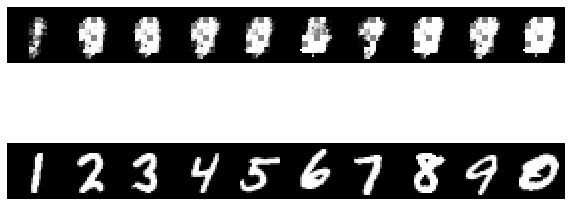


Average Loss at Epoch 1: 	 0.715813 

Average loss at Test set: 	 0.6833 



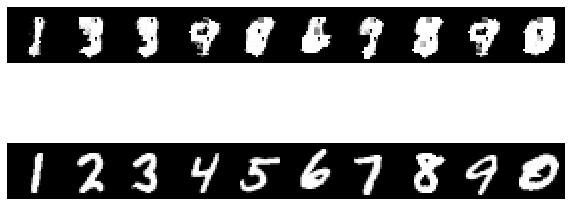


Average Loss at Epoch 2: 	 0.660700 

Average loss at Test set: 	 0.6509 



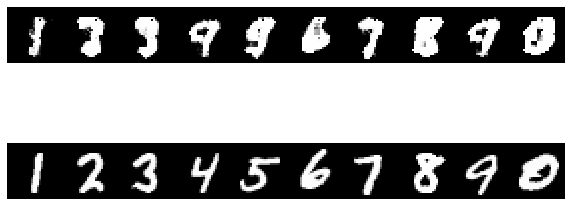


Average Loss at Epoch 3: 	 0.637035 

Average loss at Test set: 	 0.6296 



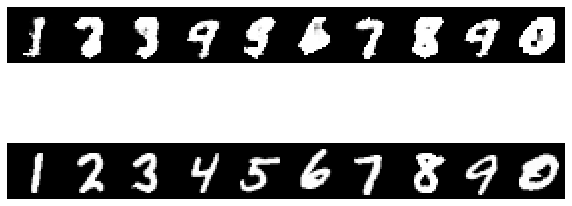


Average Loss at Epoch 4: 	 0.620273 

Average loss at Test set: 	 0.6214 



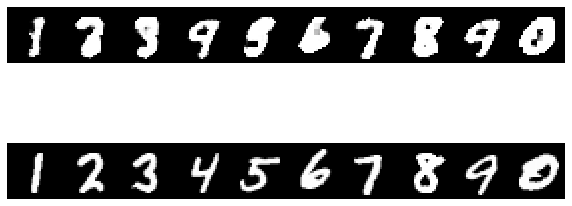


Average Loss at Epoch 5: 	 0.615285 

Average loss at Test set: 	 0.6179 



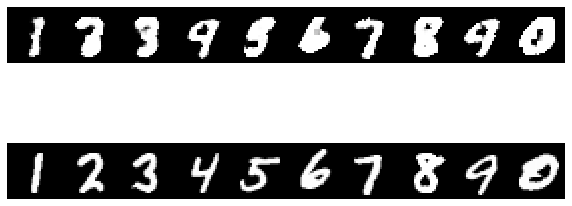


Average Loss at Epoch 6: 	 0.611925 

Average loss at Test set: 	 0.6153 



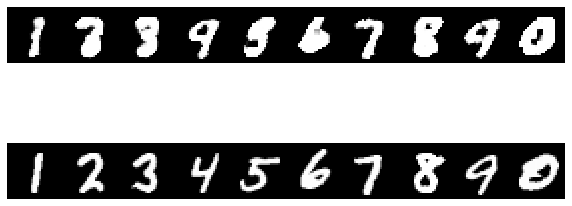


Average Loss at Epoch 7: 	 0.609414 

Average loss at Test set: 	 0.6134 



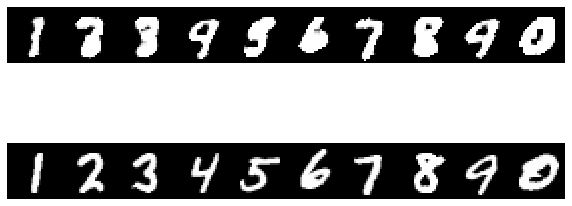


Average Loss at Epoch 8: 	 0.607486 

Average loss at Test set: 	 0.6110 



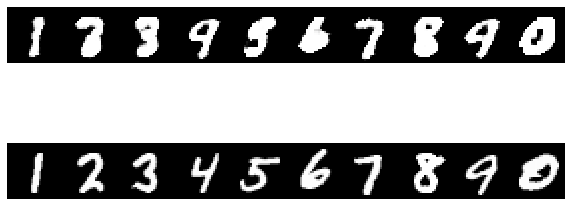


Average Loss at Epoch 9: 	 0.605983 

Average loss at Test set: 	 0.6101 



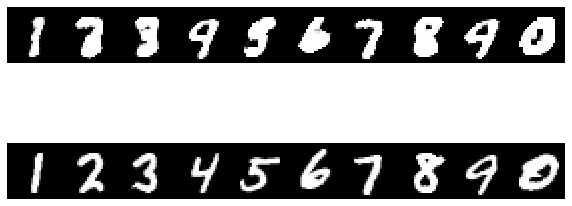


Average Loss at Epoch 10: 	 0.604702 

Average loss at Test set: 	 0.6089 



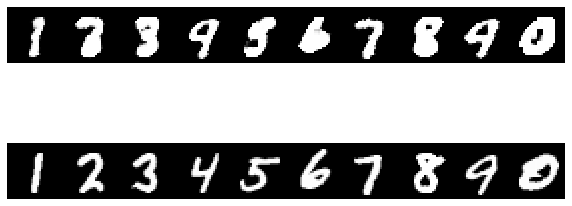


Average Loss at Epoch 11: 	 0.603565 

Average loss at Test set: 	 0.6078 



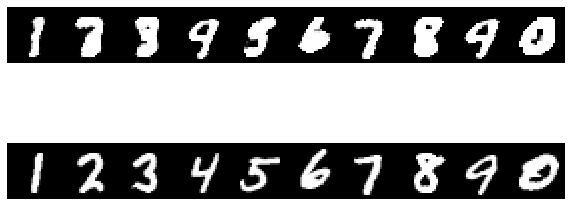


Average Loss at Epoch 12: 	 0.602582 

Average loss at Test set: 	 0.6068 



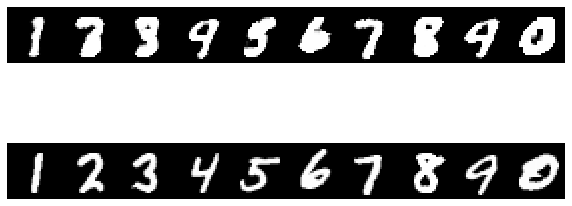


Average Loss at Epoch 13: 	 0.601380 

Average loss at Test set: 	 0.6056 



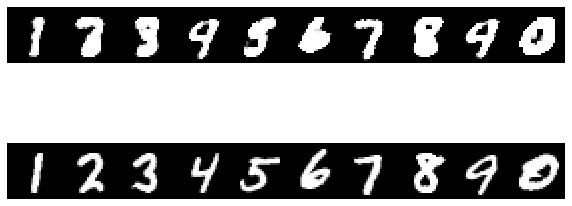


Average Loss at Epoch 14: 	 0.600442 

Average loss at Test set: 	 0.6050 



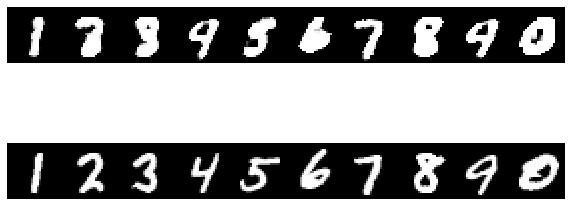


Average Loss at Epoch 15: 	 0.599430 

Average loss at Test set: 	 0.6034 



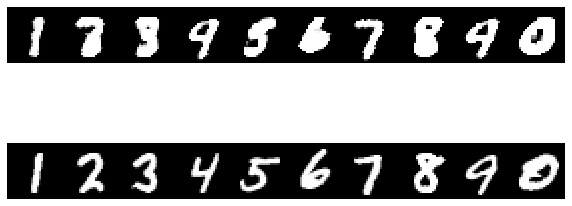


Average Loss at Epoch 16: 	 0.597038 

Average loss at Test set: 	 0.6002 



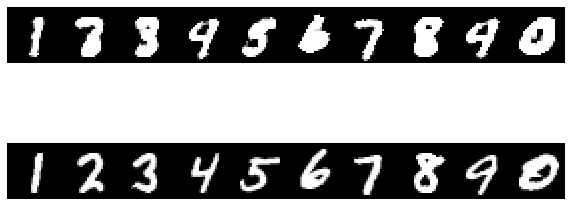


Average Loss at Epoch 17: 	 0.594763 

Average loss at Test set: 	 0.5993 



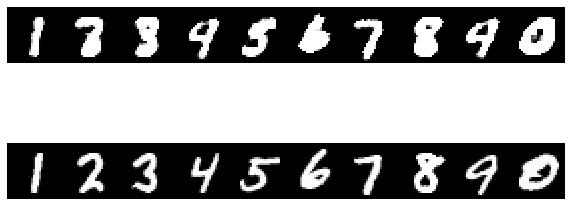


Average Loss at Epoch 18: 	 0.593912 

Average loss at Test set: 	 0.5984 



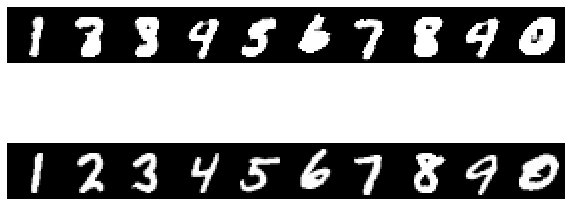


Average Loss at Epoch 19: 	 0.593232 

Average loss at Test set: 	 0.5985 



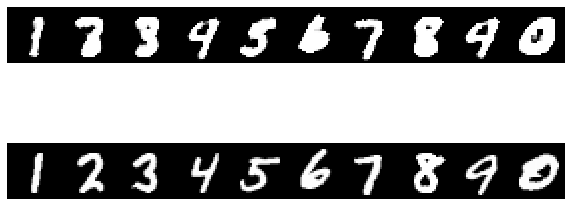

Model with 50 bottleneck size:

Average Loss at Epoch 0: 	 0.829294 

Average loss at Test set: 	 0.7194 



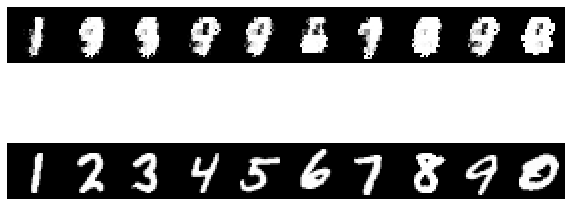


Average Loss at Epoch 1: 	 0.675361 

Average loss at Test set: 	 0.6514 



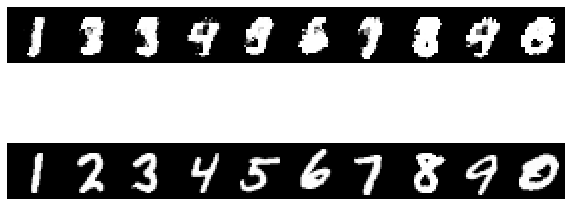


Average Loss at Epoch 2: 	 0.628162 

Average loss at Test set: 	 0.6193 



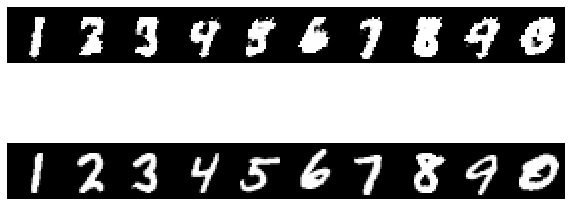


Average Loss at Epoch 3: 	 0.605481 

Average loss at Test set: 	 0.6016 



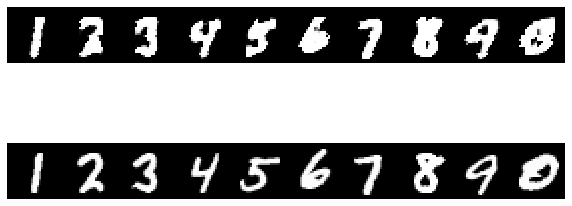


Average Loss at Epoch 4: 	 0.590983 

Average loss at Test set: 	 0.5902 



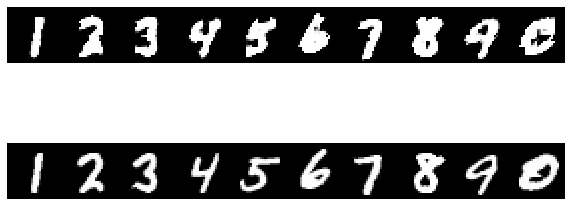


Average Loss at Epoch 5: 	 0.581283 

Average loss at Test set: 	 0.5826 



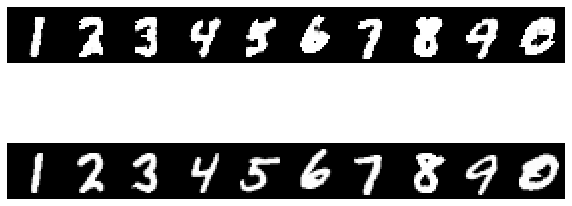


Average Loss at Epoch 6: 	 0.572444 

Average loss at Test set: 	 0.5727 



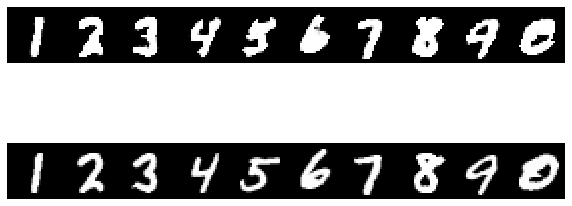


Average Loss at Epoch 7: 	 0.565818 

Average loss at Test set: 	 0.5685 



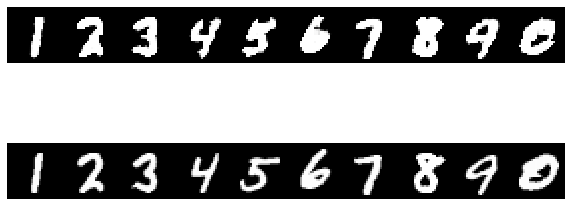


Average Loss at Epoch 8: 	 0.561341 

Average loss at Test set: 	 0.5651 



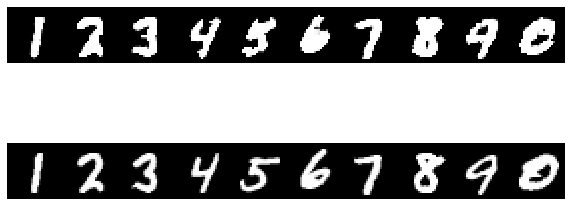


Average Loss at Epoch 9: 	 0.557690 

Average loss at Test set: 	 0.5611 



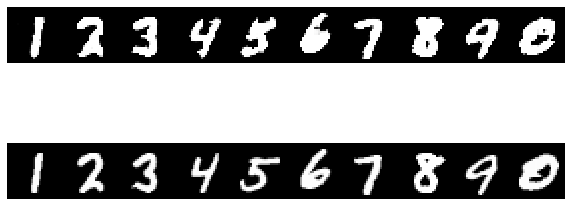


Average Loss at Epoch 10: 	 0.554197 

Average loss at Test set: 	 0.5586 



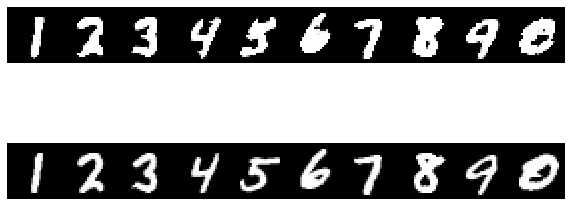


Average Loss at Epoch 11: 	 0.551955 

Average loss at Test set: 	 0.5566 



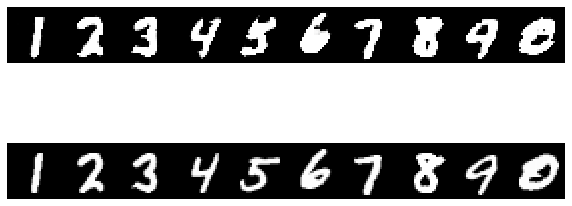


Average Loss at Epoch 12: 	 0.550079 

Average loss at Test set: 	 0.5555 



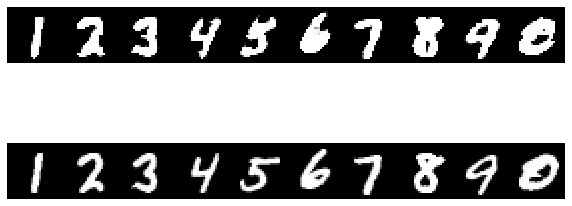


Average Loss at Epoch 13: 	 0.548070 

Average loss at Test set: 	 0.5519 



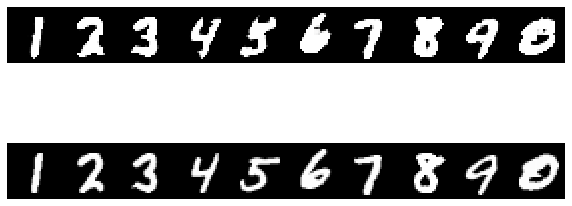


Average Loss at Epoch 14: 	 0.545806 

Average loss at Test set: 	 0.5510 



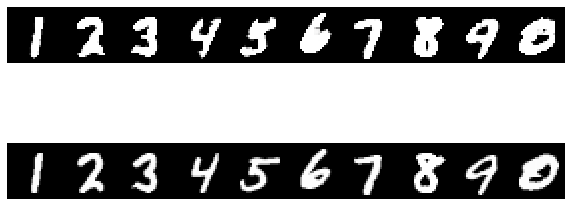


Average Loss at Epoch 15: 	 0.544702 

Average loss at Test set: 	 0.5501 



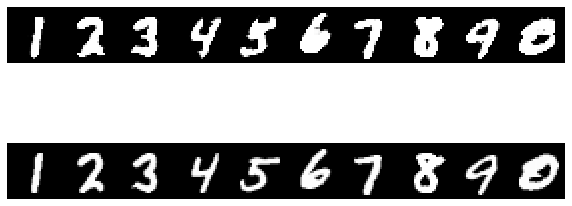


Average Loss at Epoch 16: 	 0.544090 

Average loss at Test set: 	 0.5493 



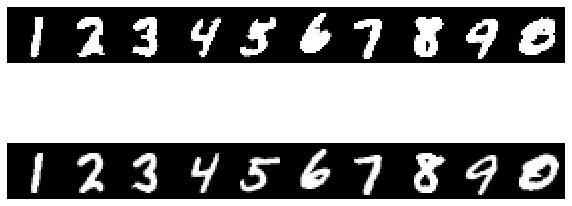


Average Loss at Epoch 17: 	 0.543295 

Average loss at Test set: 	 0.5487 



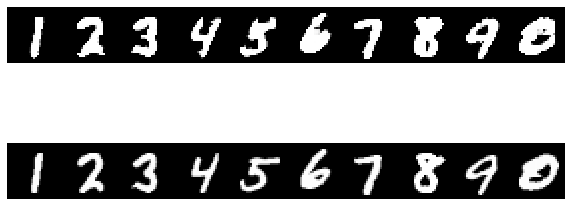


Average Loss at Epoch 18: 	 0.542705 

Average loss at Test set: 	 0.5482 



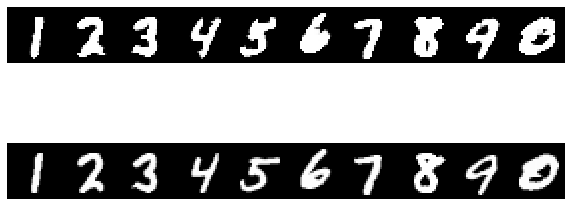


Average Loss at Epoch 19: 	 0.542250 

Average loss at Test set: 	 0.5475 



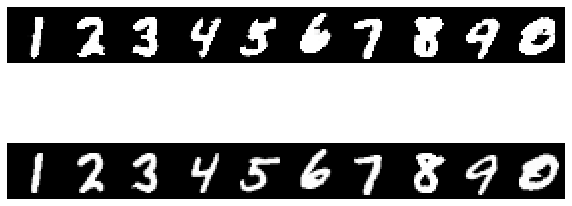

Model with 100 bottleneck size:

Average Loss at Epoch 0: 	 0.830868 

Average loss at Test set: 	 0.6983 



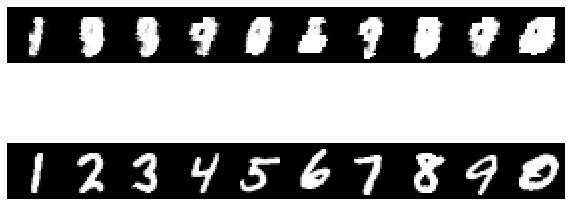


Average Loss at Epoch 1: 	 0.656247 

Average loss at Test set: 	 0.6349 



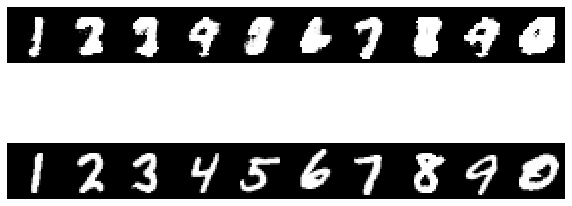


Average Loss at Epoch 2: 	 0.619186 

Average loss at Test set: 	 0.6147 



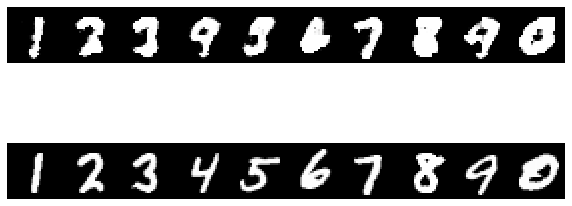


Average Loss at Epoch 3: 	 0.602823 

Average loss at Test set: 	 0.6020 



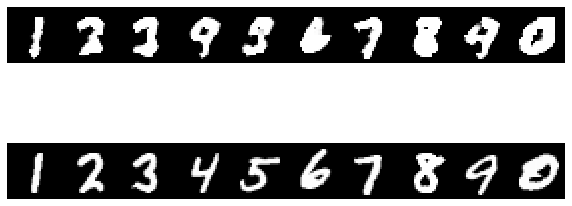


Average Loss at Epoch 4: 	 0.593248 

Average loss at Test set: 	 0.5944 



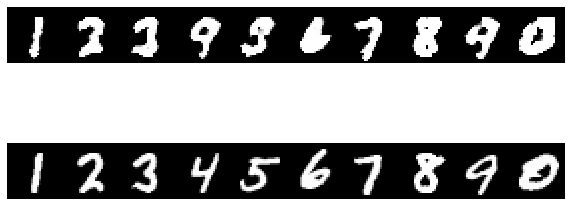


Average Loss at Epoch 5: 	 0.584641 

Average loss at Test set: 	 0.5866 



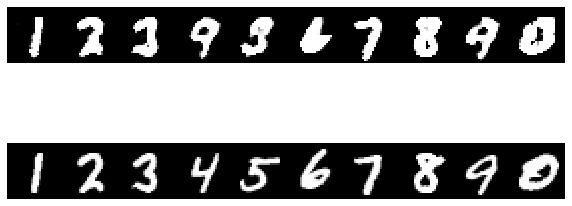


Average Loss at Epoch 6: 	 0.579241 

Average loss at Test set: 	 0.5825 



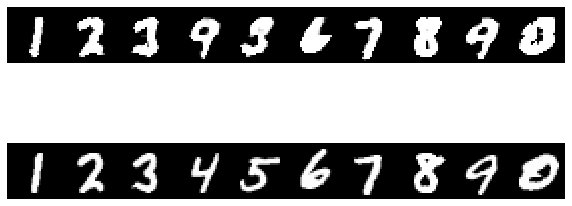


Average Loss at Epoch 7: 	 0.575778 

Average loss at Test set: 	 0.5795 



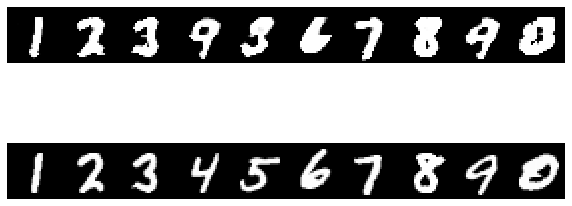


Average Loss at Epoch 8: 	 0.573172 

Average loss at Test set: 	 0.5767 



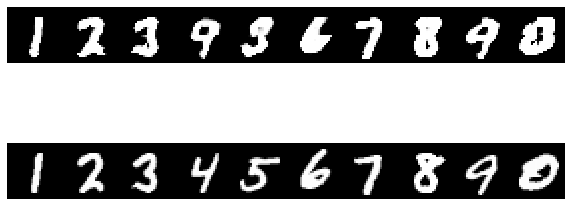


Average Loss at Epoch 9: 	 0.570444 

Average loss at Test set: 	 0.5743 



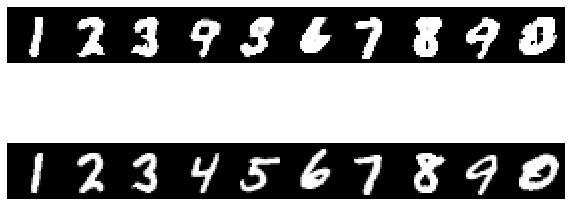


Average Loss at Epoch 10: 	 0.568644 

Average loss at Test set: 	 0.5728 



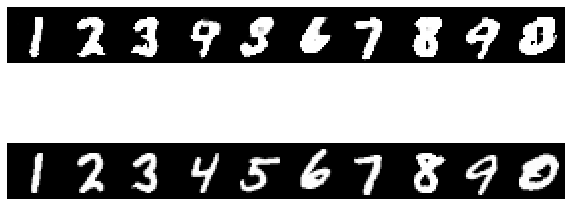


Average Loss at Epoch 11: 	 0.567170 

Average loss at Test set: 	 0.5721 



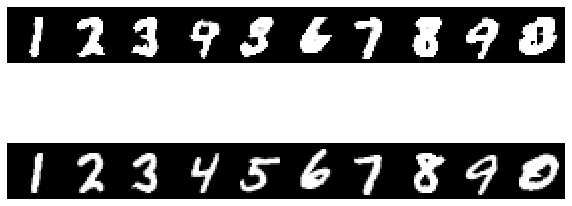


Average Loss at Epoch 12: 	 0.566111 

Average loss at Test set: 	 0.5711 



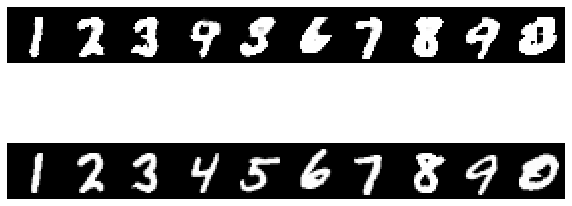


Average Loss at Epoch 13: 	 0.565197 

Average loss at Test set: 	 0.5703 



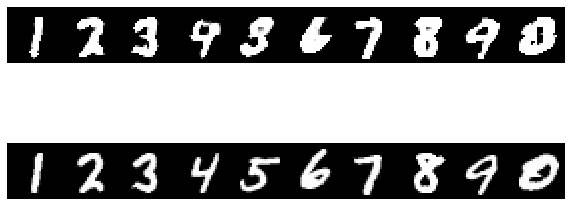


Average Loss at Epoch 14: 	 0.564233 

Average loss at Test set: 	 0.5688 



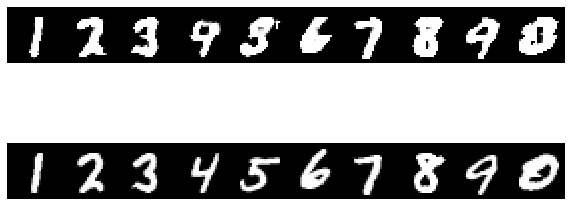


Average Loss at Epoch 15: 	 0.562915 

Average loss at Test set: 	 0.5674 



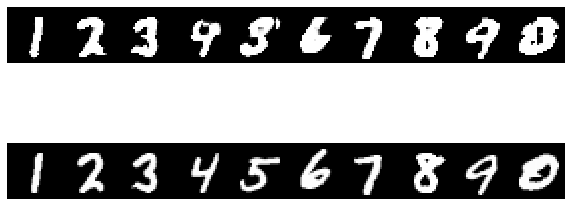


Average Loss at Epoch 16: 	 0.561545 

Average loss at Test set: 	 0.5668 



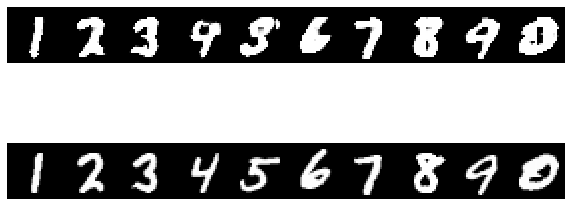


Average Loss at Epoch 17: 	 0.560458 

Average loss at Test set: 	 0.5655 



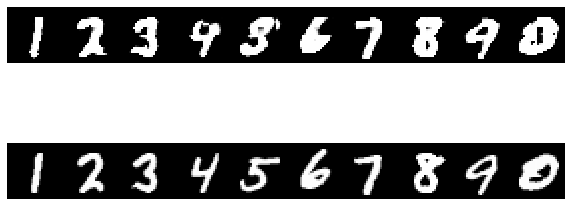


Average Loss at Epoch 18: 	 0.559857 

Average loss at Test set: 	 0.5648 



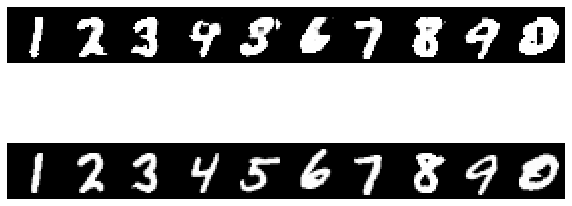


Average Loss at Epoch 19: 	 0.559172 

Average loss at Test set: 	 0.5643 



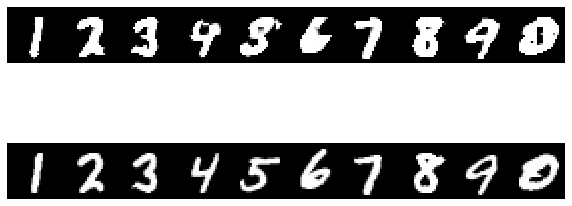

Model with 512 bottleneck size:

Average Loss at Epoch 0: 	 0.789120 

Average loss at Test set: 	 0.6625 



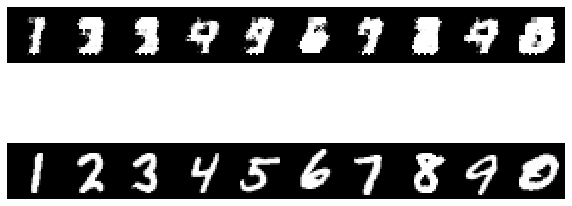


Average Loss at Epoch 1: 	 0.618671 

Average loss at Test set: 	 0.5955 



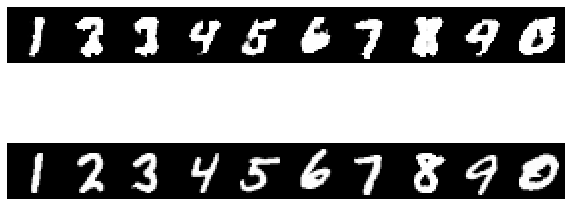


Average Loss at Epoch 2: 	 0.576604 

Average loss at Test set: 	 0.5757 



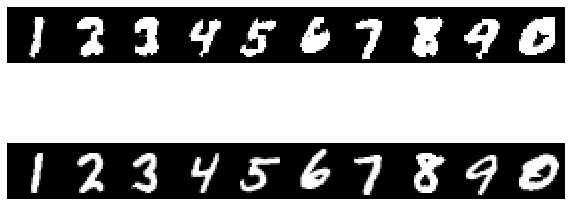


Average Loss at Epoch 3: 	 0.564516 

Average loss at Test set: 	 0.5672 



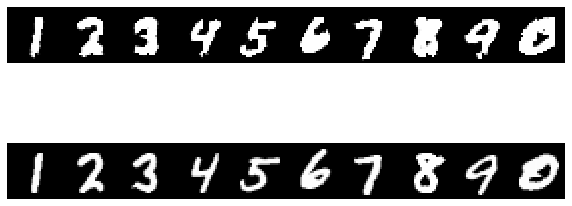


Average Loss at Epoch 4: 	 0.558059 

Average loss at Test set: 	 0.5622 



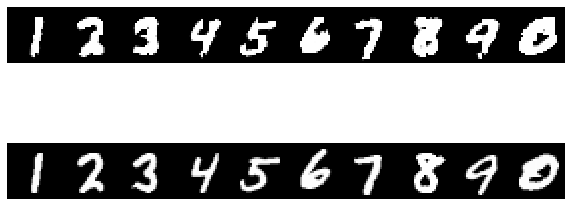


Average Loss at Epoch 5: 	 0.552853 

Average loss at Test set: 	 0.5567 



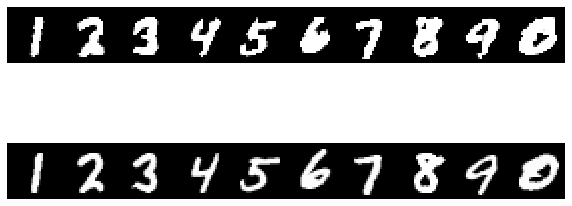


Average Loss at Epoch 6: 	 0.548588 

Average loss at Test set: 	 0.5537 



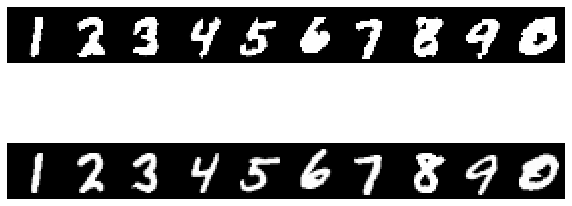


Average Loss at Epoch 7: 	 0.546040 

Average loss at Test set: 	 0.5512 



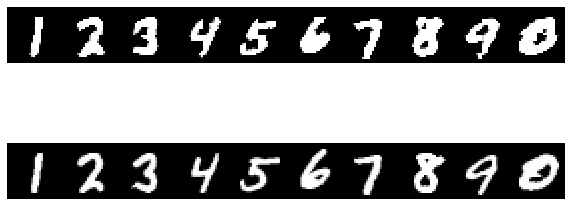


Average Loss at Epoch 8: 	 0.541847 

Average loss at Test set: 	 0.5469 



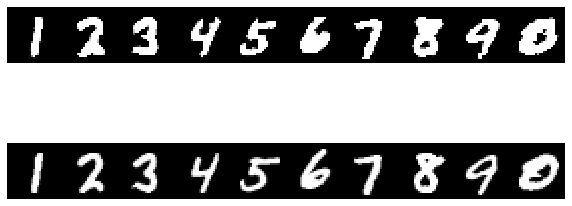


Average Loss at Epoch 9: 	 0.539311 

Average loss at Test set: 	 0.5448 



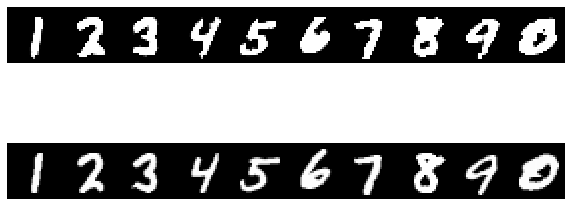


Average Loss at Epoch 10: 	 0.537692 

Average loss at Test set: 	 0.5433 



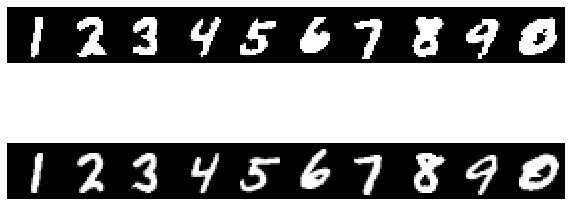


Average Loss at Epoch 11: 	 0.536410 

Average loss at Test set: 	 0.5422 



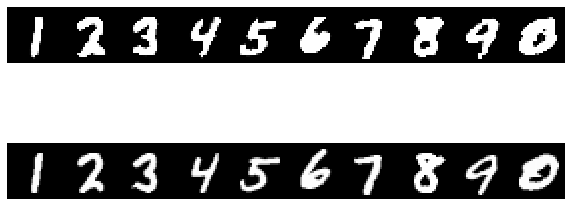


Average Loss at Epoch 12: 	 0.535445 

Average loss at Test set: 	 0.5421 



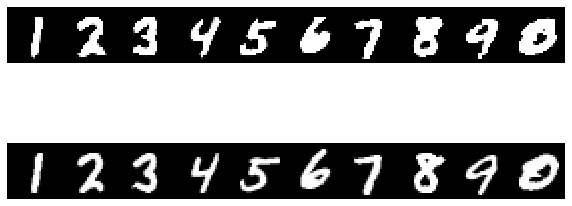


Average Loss at Epoch 13: 	 0.534593 

Average loss at Test set: 	 0.5412 



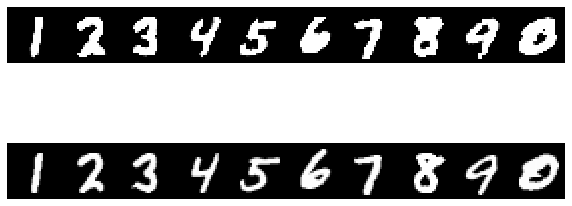


Average Loss at Epoch 14: 	 0.533860 

Average loss at Test set: 	 0.5401 



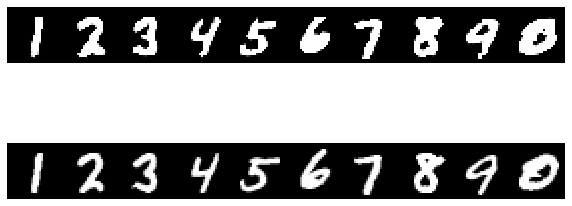


Average Loss at Epoch 15: 	 0.533014 

Average loss at Test set: 	 0.5396 



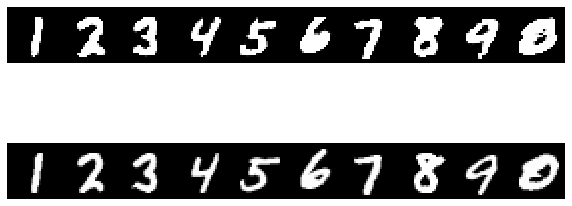


Average Loss at Epoch 16: 	 0.532408 

Average loss at Test set: 	 0.5393 



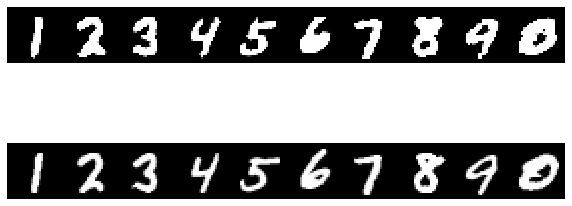


Average Loss at Epoch 17: 	 0.531722 

Average loss at Test set: 	 0.5382 



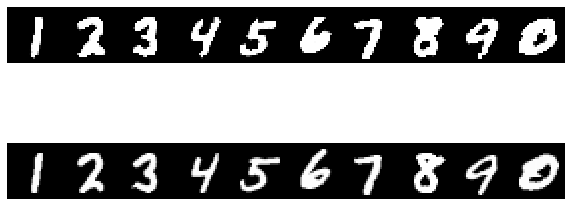


Average Loss at Epoch 18: 	 0.531190 

Average loss at Test set: 	 0.5381 



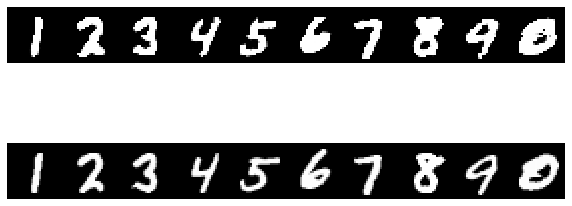


Average Loss at Epoch 19: 	 0.530775 

Average loss at Test set: 	 0.5374 



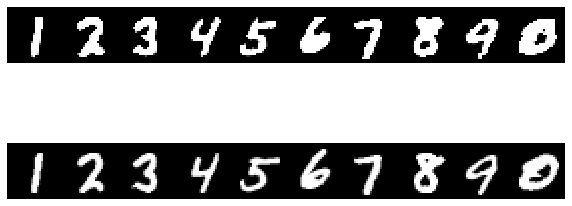

In [0]:
criterion = nn.MSELoss()

losses = defaultdict(lambda: defaultdict(list))
models = []
for bt in [10,50,100,512]:
    models.append(ConvolutionalAutoEncoder(bt).cuda())
for m in models:
    print('Model with '+str(m.bottleneck)+' bottleneck size:')
    params = list(m.encoder.parameters()) + list(m.decoder.parameters())
    optimizer = torch.optim.Adam(params, lr=hparams['learning_rate'], weight_decay=1e-5)
    for epoch in range(hparams['num_epochs']):
      losses[m.bottleneck]['train'].append(train_epoch(m, train_loader, optimizer, criterion, hparams, False))
      losses[m.bottleneck]['test'].append(test_epoch(m, test_loader, criterion, hparams, False))
    save_model(str(m.bottleneck), m.state_dict())


<function matplotlib.pyplot.show>

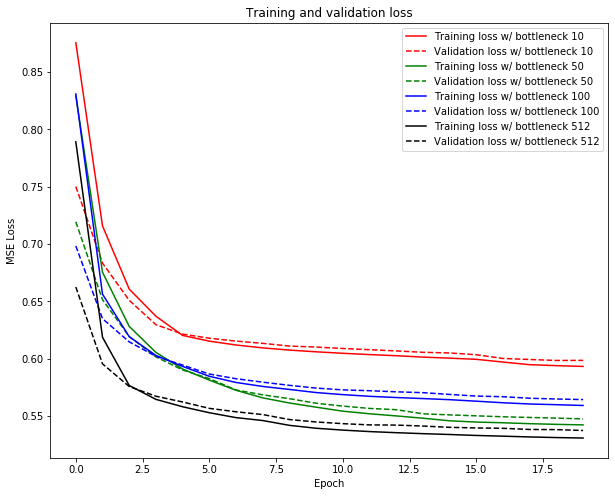

In [0]:
plt.figure(figsize=(10, 8))
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

bottlenecks = [10,50,100,512]
colors = ['r', 'g', 'b', 'k']

for bt, c in zip(bottlenecks, colors):
  plt.plot(losses[bt]['train'], c, label='Training loss w/ bottleneck ' + str(bt))
  plt.plot(losses[bt]['test'], c + '--', label='Validation loss w/ bottleneck ' + str(bt))

plt.title('Training and validation loss')
plt.legend()
plt.show

In [0]:
# Execute only in case we want to use already trained models. Weights stored in Google Drive.
models = []
bottlenecks = [10,50,100,512]
for bt in bottlenecks:
  m = ConvolutionalAutoEncoder(bt).cuda()
  weights = load_weights(str(bt))
  m.load_state_dict(weights)
  models.append(m)

#4. Compute the avg. image reconstruction error (MSE) 

of the trained models on the MNIST validation and test sets. 

Show the results in a table, including #params of each model.

In [0]:
def get_nn_nparams(model):
  """ https://discuss.pytorch.org/t/how-do-i-check-the-number-of-parameters-of-a-model/4325/6 """
  pp=0
  for p in list(model.parameters()):
      nn=1
      for s in list(p.size()):
          nn = nn*s
      pp += nn
  return pp

Average loss at Test set: 	 0.5969 



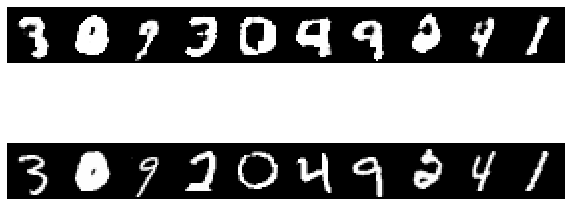

Average loss at Test set: 	 0.5985 



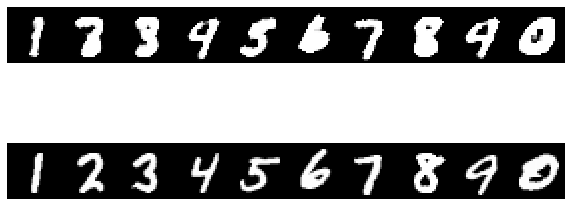

Average loss at Test set: 	 0.5449 



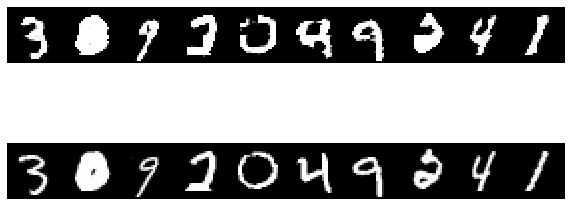

Average loss at Test set: 	 0.5475 



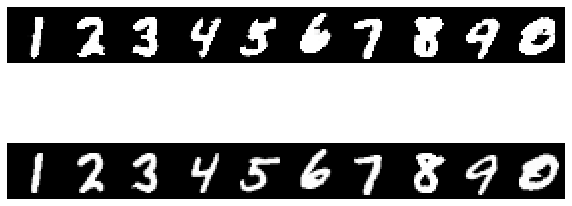

Average loss at Test set: 	 0.5622 



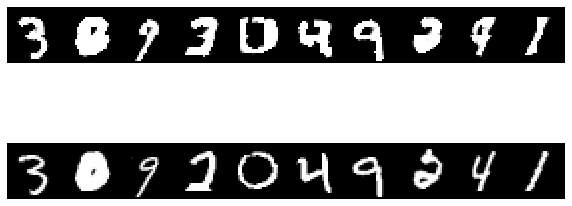

Average loss at Test set: 	 0.5643 



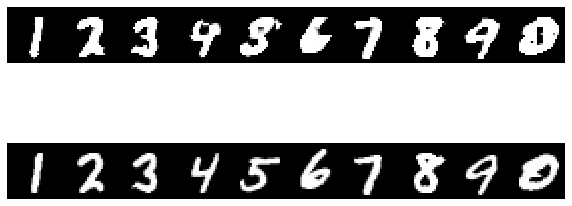

Average loss at Test set: 	 0.5336 



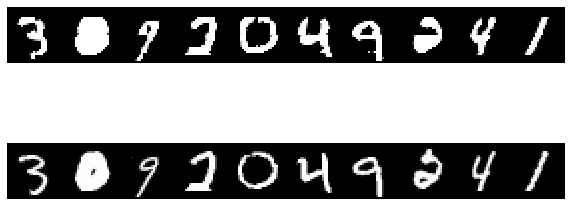

Average loss at Test set: 	 0.5374 



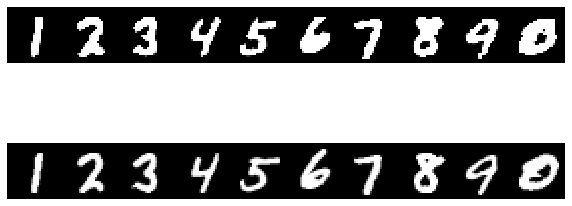

+--------+--------------------+--------------------+------------+
| model  |      MSE eval      |      MSE test      | parameters |
+--------+--------------------+--------------------+------------+
| model1 | 0.5969250102837881 | 0.5985150216500971 |    7977    |
| model2 | 0.5449443484346072 | 0.5474700599531584 |   28897    |
| model3 | 0.5622252027193705 | 0.5643133389044411 |   55047    |
| model4 | 0.5336301724116007 | 0.5373528309260742 |   270523   |
+--------+--------------------+--------------------+------------+


In [0]:
mse_eval = []
mse_test = []
parameters = []

t = PrettyTable(['model', 'MSE eval', 'MSE test', 'parameters'])

#ho poso com si els models estiguessin guardats en una llista ja
for mod, n in zip(models, range(len(models))):
  mse_eval.append(test_epoch(mod, val_loader, criterion, hparams, False))
  mse_test.append(test_epoch(mod, test_loader, criterion, hparams, False))
  parameters.append(get_nn_nparams(mod))
  t.add_row(['model'+str(n+1), mse_eval[n], mse_test[n], parameters[n]])

print(t)

#5. Select one of the autoencoders and feed it 5 random MNIST images from the test set. 

Show them along with their reconstructions.

torch.Size([1, 28, 28])


<Figure size 432x288 with 0 Axes>

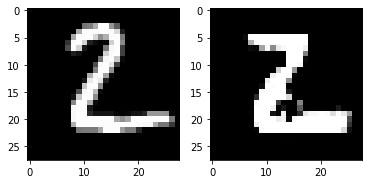

torch.Size([1, 28, 28])


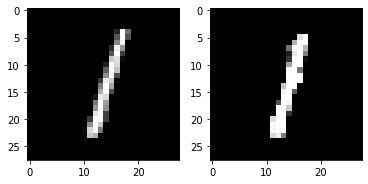

torch.Size([1, 28, 28])


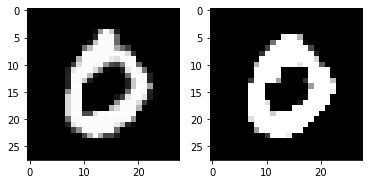

torch.Size([1, 28, 28])


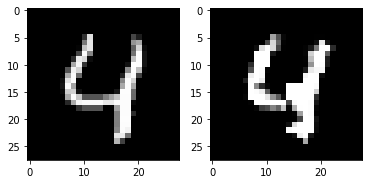

torch.Size([1, 28, 28])


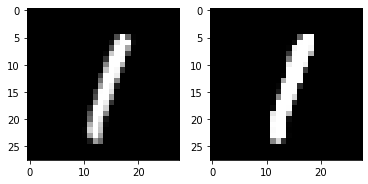

In [0]:
dataiter = iter(test_loader)
images, _ = dataiter.next()

figure = plt.figure()
num_of_images = 5
for index in range(1, num_of_images + 1):
    print(images[index].shape)
    img=images[index].reshape(1, 1, 28, 28).to(hparams['device'])
    img = Variable(img.cuda())
    output = models[3](img) #AQUI S'HA DE CANVIAR EL MODEL

    img=img.reshape(28, 28)
    output = output.reshape(28, 28)
    
    a = img.detach().cpu().numpy()
    b = output.detach().cpu().numpy()
    f, arr = plt.subplots(1,2)

    arr[0].imshow(a, cmap='gray')
    arr[1].imshow(b, cmap='gray')
    plt.show()

#6. Generate 5 new images by injecting random values as input to the decoder.

Image 0


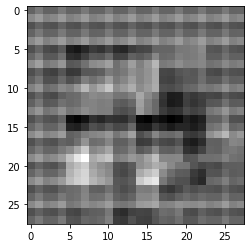

Image 1


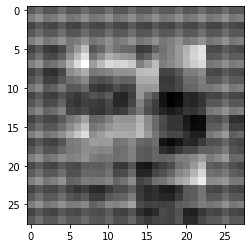

Image 2


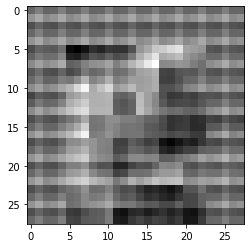

Image 3


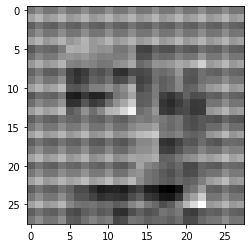

Image 4


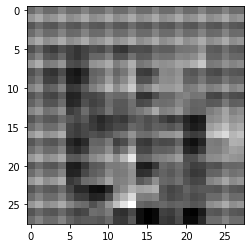

In [0]:
model = models[3]
for n in range(5):
  noise_image = torch.randn([1,model.bottleneck]).cuda()
  output = model.decoder(noise_image)
  print('Image '+str(n))
  plt.imshow(output.cpu().detach().numpy().squeeze(), cmap='gray')
  plt.show()
  

#**PART 2:**

#1. Select a subset of 100 images and their associated labels from the MNIST training data.

In [0]:
sub_size = 100
sub_dataset, _ = torch.utils.data.random_split(mnist_trainset, [sub_size, len(mnist_trainset)-sub_size])

sub_loader = torch.utils.data.DataLoader(
      sub_dataset,
      batch_size=100,
      shuffle=True)

In [0]:
#checkings
print(len(sub_dataset))
print(len(sub_loader.dataset))

100
100


###Distribution of our subset

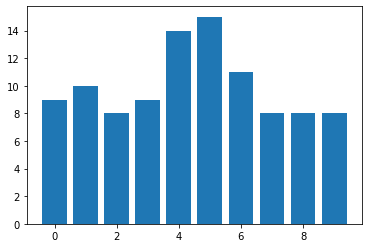

In [0]:
img, labels = iter(sub_loader).next()
lab = labels.numpy()
unique, counts = np.unique(lab, return_counts=True)
plt.bar(unique, counts)
plt.show()

#2 & 3. Select one of the previously trained autoencoders.

Create a digit (0-9) classification model reusing the encoder of the autoencoder and adding the needed fully connected (projection) layer.

In [0]:
#Checkings
image = torch.randn((100, 1, 28, 28))
output = models[3].forward_classifier(image.to(hparams['device']))
print(output.shape)

torch.Size([100, 10])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


#4. Pre-training: 

use the weights of the autoencoder as initial values for the network weights and train a classification model on the subset of 100 samples.

In [0]:
# General stuff
criterion = nn.NLLLoss()

loss_classifiers = defaultdict(lambda: defaultdict(list))

# We choose the model with bottleneck = 512.
bt = 512
model_init = ConvolutionalAutoEncoder(bt).cuda()

# To check
print('Before weight initialize')
print(model_init.encoder.encoder[0].weight[0].data)
print(model_init.linear[0].weight[0].data[:4])

# Load the weights from autoencoder trained before
weights = load_weights(str(bt))
model_init.load_state_dict(weights)
# WITH DEEPCOPY
model_init2 = ConvolutionalAutoEncoder(bt).cuda()
model_init2.encoder = copy.deepcopy(models[3].encoder)

print('After weight initialize')
print(model_init.encoder.encoder[0].weight[0].data)
print(model_init.linear[0].weight[0].data[:4])
print(model_init2.encoder.encoder[0].weight[0].data)
print(model_init2.linear[0].weight[0].data[:4])
print('Weight model base')
print(models[3].encoder.encoder[0].weight[0].data)

Before weight initialize
tensor([[[ 0.2989,  0.0795, -0.3125],
         [ 0.1398, -0.0444,  0.3109],
         [ 0.0920, -0.3055,  0.1226]]], device='cuda:0')
tensor([ 0.0132, -0.0035, -0.0341, -0.0305], device='cuda:0')
After weight initialize
tensor([[[ 1.6242,  0.5166, -0.0517],
         [ 0.7656,  0.3343, -0.2185],
         [ 0.5213, -0.1847, -0.4361]]], device='cuda:0')
tensor([ 0.0402, -0.0306,  0.0070,  0.0236], device='cuda:0')
tensor([[[ 1.6242,  0.5166, -0.0517],
         [ 0.7656,  0.3343, -0.2185],
         [ 0.5213, -0.1847, -0.4361]]], device='cuda:0')
tensor([ 0.0359,  0.0199,  0.0004, -0.0219], device='cuda:0')
Weight model base
tensor([[[ 1.6242,  0.5166, -0.0517],
         [ 0.7656,  0.3343, -0.2185],
         [ 0.5213, -0.1847, -0.4361]]], device='cuda:0')


In [0]:
# We'll pass the encoder and linear parameters to the optimizer
params = list(model_init.encoder.parameters()) + list(model_init.linear.parameters())
optimizer = torch.optim.Adam(params, lr=hparams['learning_rate'], weight_decay=1e-5)

print('Model with '+str(model_init.bottleneck)+' bottleneck size:')
for epoch in range(hparams['num_epochs']):
  loss_classifiers['init']['train'].append(train_epoch(model_init, sub_loader, optimizer, criterion, hparams, True))

Model with 512 bottleneck size:

Average Loss at Epoch 0: 	 -0.138902 


Average Loss at Epoch 1: 	 -0.270647 


Average Loss at Epoch 2: 	 -0.290170 


Average Loss at Epoch 3: 	 -0.259342 


Average Loss at Epoch 4: 	 -0.309121 


Average Loss at Epoch 5: 	 -0.305572 


Average Loss at Epoch 6: 	 -0.309268 


Average Loss at Epoch 7: 	 -0.310583 


Average Loss at Epoch 8: 	 -0.316684 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Average Loss at Epoch 9: 	 -0.319880 


Average Loss at Epoch 10: 	 -0.319933 


Average Loss at Epoch 11: 	 -0.319908 


Average Loss at Epoch 12: 	 -0.319816 


Average Loss at Epoch 13: 	 -0.319682 


Average Loss at Epoch 14: 	 -0.319646 


Average Loss at Epoch 15: 	 -0.319758 


Average Loss at Epoch 16: 	 -0.319865 


Average Loss at Epoch 17: 	 -0.319919 


Average Loss at Epoch 18: 	 -0.319945 


Average Loss at Epoch 19: 	 -0.319958 



#5. Fine-tuning: 

do the same, but train the new projection layer with a normal learning rate and the reused part with a very low learning rate.

In [0]:
# We choose the model with bottleneck = 512.
bt = 512
model_finetuned = ConvolutionalAutoEncoder(bt).cuda()

# To check
print('Before weight initialize')
print(model_finetuned.encoder.encoder[0].weight[0].data)
print(model_finetuned.linear[0].weight[0].data[:4])

# Load the weights from autoencoder trained before
weights = load_weights(str(bt))
model_finetuned.load_state_dict(weights)

print('After weight initialize')
print(model_finetuned.encoder.encoder[0].weight[0].data)
print(model_finetuned.linear[0].weight[0].data[:4])
print('Weight model base')
print(models[3].encoder.encoder[0].weight[0].data)

Before weight initialize
tensor([[[-0.3154,  0.0549,  0.2923],
         [-0.0179,  0.3238,  0.1339],
         [ 0.0051,  0.3044, -0.2432]]], device='cuda:0')
tensor([-0.0009, -0.0413, -0.0343,  0.0017], device='cuda:0')
After weight initialize
tensor([[[ 1.6242,  0.5166, -0.0517],
         [ 0.7656,  0.3343, -0.2185],
         [ 0.5213, -0.1847, -0.4361]]], device='cuda:0')
tensor([ 0.0402, -0.0306,  0.0070,  0.0236], device='cuda:0')
Weight model base
tensor([[[ 1.6242,  0.5166, -0.0517],
         [ 0.7656,  0.3343, -0.2185],
         [ 0.5213, -0.1847, -0.4361]]], device='cuda:0')


In [0]:
# We'll pass the encoder and linear parameters to the optimizer with their
# respective learning rates
optimizer = torch.optim.Adam([
                {'params': model_finetuned.linear.parameters()},
                {'params': model_finetuned.encoder.parameters(), 'lr': 1e-6}
            ], hparams['learning_rate'], weight_decay=1e-5)

print('Model with '+str(model_finetuned.bottleneck)+' bottleneck size:')
for epoch in range(hparams['num_epochs']):
  loss_classifiers['finetuned']['train'].append(train_epoch(model_finetuned, sub_loader, optimizer, criterion, hparams, True))
       

Model with 512 bottleneck size:

Average Loss at Epoch 0: 	 -0.138902 


Average Loss at Epoch 1: 	 -0.225297 


Average Loss at Epoch 2: 	 -0.271066 


Average Loss at Epoch 3: 	 -0.305366 


Average Loss at Epoch 4: 	 -0.330948 


Average Loss at Epoch 5: 	 -0.340179 


Average Loss at Epoch 6: 	 -0.356486 


Average Loss at Epoch 7: 	 -0.377830 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Average Loss at Epoch 8: 	 -0.389630 


Average Loss at Epoch 9: 	 -0.395542 


Average Loss at Epoch 10: 	 -0.396826 


Average Loss at Epoch 11: 	 -0.397830 


Average Loss at Epoch 12: 	 -0.398546 


Average Loss at Epoch 13: 	 -0.399274 


Average Loss at Epoch 14: 	 -0.399968 


Average Loss at Epoch 15: 	 -0.400681 


Average Loss at Epoch 16: 	 -0.402248 


Average Loss at Epoch 17: 	 -0.408703 


Average Loss at Epoch 18: 	 -0.417356 


Average Loss at Epoch 19: 	 -0.419003 



#6. From scratch: 

train the model on the 100 samples without reusing the decoder weights at all.

In [0]:
# We choose the model with bottleneck = 512.
bt = 512
model_simple = ConvolutionalAutoEncoder(bt).cuda()

# We'll pass the encoder and linear parameters to the optimizer
params = list(model_simple.encoder.parameters()) + list(model_simple.linear.parameters())
optimizer = torch.optim.Adam(params, lr=hparams['learning_rate'], weight_decay=1e-5)

print('Model with '+str(model_simple.bottleneck)+' bottleneck size:')
for epoch in range(hparams['num_epochs']):
  loss_classifiers['simple']['train'].append(train_epoch(model_simple, sub_loader, optimizer, criterion, hparams, True))

Model with 512 bottleneck size:

Average Loss at Epoch 0: 	 -0.099852 


Average Loss at Epoch 1: 	 -0.101303 


Average Loss at Epoch 2: 	 -0.102908 


Average Loss at Epoch 3: 	 -0.104721 


Average Loss at Epoch 4: 	 -0.106807 


Average Loss at Epoch 5: 	 -0.109263 


Average Loss at Epoch 6: 	 -0.112110 



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Average Loss at Epoch 7: 	 -0.115439 


Average Loss at Epoch 8: 	 -0.119388 


Average Loss at Epoch 9: 	 -0.124056 


Average Loss at Epoch 10: 	 -0.129614 


Average Loss at Epoch 11: 	 -0.136233 


Average Loss at Epoch 12: 	 -0.143990 


Average Loss at Epoch 13: 	 -0.152909 


Average Loss at Epoch 14: 	 -0.162868 


Average Loss at Epoch 15: 	 -0.173650 


Average Loss at Epoch 16: 	 -0.185229 


Average Loss at Epoch 17: 	 -0.198120 


Average Loss at Epoch 18: 	 -0.213296 


Average Loss at Epoch 19: 	 -0.231188 



#7. Show the accuracy of the four models on the MNIST test set in a table.

In [0]:
def test_epoch_class(model, test_data, criterion, hparams):
  model.eval()
  device = hparams['device']
  mean_loss = 0
  mean_acc = 0
  
  with torch.no_grad():
      for data, target in test_data:
            img, label = data.to(device), target.to(device) #128x1x28x28, 128

            output = model.forward_classifier(img) #128x10
            loss = criterion(output, label)

            mean_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability, 128x1
            mean_acc += pred.eq(label.view_as(pred)).sum().item() # compare the predicted class index with the index in its corresponding label and accumulate the sum of the possitive values
   
  mean_loss = mean_loss/len(test_data)   
  mean_acc = mean_acc / len(test_data.dataset)
  print('\nTest set: Average loss: \t {:.4f}\n\t Accuracy: \t{:.2f}\n'.format(
        mean_loss, mean_acc))

  return mean_loss, mean_acc

In [0]:
t2 = PrettyTable(['model', 'accuracy', 'loss'])

#ho poso com si els models estiguessin guardats en una llista ja
for mod, typ in zip([model_init2, model_finetuned2, model_simple], ['init', 'fine', 'simple']):
  loss,accuracy = test_epoch_class(mod, test_loader, criterion, hparams)

  t2.add_row([typ+' model', str(int(100*accuracy))+'%', loss])

print(t2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 	 -0.1679
	 Accuracy: 	0.17


Test set: Average loss: 	 -0.2761
	 Accuracy: 	0.28


Test set: Average loss: 	 -0.1889
	 Accuracy: 	0.26

+--------------+----------+----------------------+
|    model     | accuracy |         loss         |
+--------------+----------+----------------------+
|  init model  |   17%    | -0.1678869328166865  |
|  fine model  |   27%    | -0.27614982350717615 |
| simple model |   25%    | -0.18891062351721752 |
+--------------+----------+----------------------+


#**OPTIONAL A: VARIATIONAL AUTOENCODER**

#1. Implement an autoencoder like that from Exercise 1, but turning the deterministic bottleneck into a stochastic bottleneck, with an isotropic Gaussian as distribution for the latent variables.

In [0]:
class Encoder_(nn.Module):
    def __init__(self, bottleneck):
        super(Encoder_, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=3, padding=1),  # b, 8, 10, 10
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=3, padding=1),  # b, 16, 4, 4
            nn.ReLU(True))
        
        
        self.linear1 = nn.Linear(16*4*4, bottleneck)
        self.linear2 = nn.Linear(16*4*4, bottleneck)

    def forward(self, x):
        x = self.encoder(x)
        x= x.view(x.shape[0], -1)
        return self.linear1(x), self.linear2(x)

In [0]:
class VAE(nn.Module):
    def __init__(self, bottleneck):
        super(VAE, self).__init__()
        self.bottleneck = bottleneck
        # Necessari per l'autoencoder:
        self.encoder = Encoder_(bottleneck)
        self.decoder = Decoder(bottleneck)


    def forward(self, x):

        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

    def reparameterize(self, mu, logvar):

        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)

        else:
            return mu

        

In [0]:
def loss_function_VAE(recon_x, x, mu, logvar, batch_size):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= batch_size * 784
    return BCE + KLD

In [0]:
def train_VAE(model, train_data, optimizer, hparams, epoch):
    model.train()
    device = hparams['device']
    train_loss=0

    for batch_idx, (data, _) in enumerate(train_data):
        data = data.to(device)

        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        loss = loss_function_VAE(recon_batch, data, mu, logvar, hparams['batch_size'])
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_data.dataset),
                100. * batch_idx / len(train_data),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_data.dataset)))
    return train_loss

In [0]:
def test_VAE(model, test_loader, hparams):
    model.eval()
    device = hparams['device']
    test_loss = 0

    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)

        data = Variable(data, volatile=True)
        output, mu, logvar = model(data)
        test_loss += loss_function_VAE(output, data, mu, logvar).item()

    a = output.cpu().numpy()
    b = data.cpu().numpy()
    f, arr = plt.subplots(2,10, figsize=(10,5), gridspec_kw = {'wspace':0, 'hspace':0})
    for i in range(0,10):
      arr[0][i].imshow(a[i][0], cmap='gray')
      arr[1][i].imshow(b[i][0], cmap='gray')
      arr[0][i].axis('off')
      arr[1][i].axis('off')
    plt.show()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Using a target size (torch.Size([128, 784])) that is different to the input size (torch.Size([128, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  This is separate from the ipykernel package so we can avoid doing imports until


Train Epoch: 1 [0/57000 (0%)]	Loss: 0.005980
Train Epoch: 1 [2560/57000 (4%)]	Loss: 0.005705
Train Epoch: 1 [5120/57000 (9%)]	Loss: 0.002084
Train Epoch: 1 [7680/57000 (13%)]	Loss: -0.021487
Train Epoch: 1 [10240/57000 (18%)]	Loss: -0.045505
Train Epoch: 1 [12800/57000 (22%)]	Loss: -0.054002
Train Epoch: 1 [15360/57000 (27%)]	Loss: -0.057270
Train Epoch: 1 [17920/57000 (31%)]	Loss: -0.059192
Train Epoch: 1 [20480/57000 (36%)]	Loss: -0.058231
Train Epoch: 1 [23040/57000 (40%)]	Loss: -0.059669
Train Epoch: 1 [25600/57000 (45%)]	Loss: -0.067090
Train Epoch: 1 [28160/57000 (49%)]	Loss: -0.073665
Train Epoch: 1 [30720/57000 (54%)]	Loss: -0.083516
Train Epoch: 1 [33280/57000 (58%)]	Loss: -0.084656
Train Epoch: 1 [35840/57000 (63%)]	Loss: -0.086621
Train Epoch: 1 [38400/57000 (67%)]	Loss: -0.093667
Train Epoch: 1 [40960/57000 (72%)]	Loss: -0.105067
Train Epoch: 1 [43520/57000 (76%)]	Loss: -0.118300
Train Epoch: 1 [46080/57000 (81%)]	Loss: -0.117732
Train Epoch: 1 [48640/57000 (85%)]	Loss: -0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Using a target size (torch.Size([40, 784])) that is different to the input size (torch.Size([40, 1, 28, 28])) is deprecated. Please ensure they have the same size.
  This is separate from the ipykernel package so we can avoid doing imports until


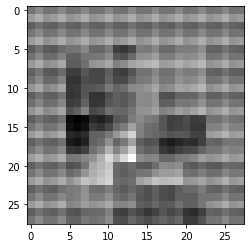

Train Epoch: 2 [0/57000 (0%)]	Loss: -0.135125
Train Epoch: 2 [2560/57000 (4%)]	Loss: -0.131581
Train Epoch: 2 [5120/57000 (9%)]	Loss: -0.138943
Train Epoch: 2 [7680/57000 (13%)]	Loss: -0.140279
Train Epoch: 2 [10240/57000 (18%)]	Loss: -0.142093
Train Epoch: 2 [12800/57000 (22%)]	Loss: -0.141265
Train Epoch: 2 [15360/57000 (27%)]	Loss: -0.143480
Train Epoch: 2 [17920/57000 (31%)]	Loss: -0.146899
Train Epoch: 2 [20480/57000 (36%)]	Loss: -0.145909
Train Epoch: 2 [23040/57000 (40%)]	Loss: -0.150654
Train Epoch: 2 [25600/57000 (45%)]	Loss: -0.147780
Train Epoch: 2 [28160/57000 (49%)]	Loss: -0.149333
Train Epoch: 2 [30720/57000 (54%)]	Loss: -0.151697
Train Epoch: 2 [33280/57000 (58%)]	Loss: -0.151787
Train Epoch: 2 [35840/57000 (63%)]	Loss: -0.152426
Train Epoch: 2 [38400/57000 (67%)]	Loss: -0.151859
Train Epoch: 2 [40960/57000 (72%)]	Loss: -0.156389
Train Epoch: 2 [43520/57000 (76%)]	Loss: -0.156818
Train Epoch: 2 [46080/57000 (81%)]	Loss: -0.155663
Train Epoch: 2 [48640/57000 (85%)]	Loss: 

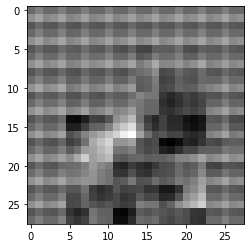

Train Epoch: 3 [0/57000 (0%)]	Loss: -0.155730
Train Epoch: 3 [2560/57000 (4%)]	Loss: -0.156639
Train Epoch: 3 [5120/57000 (9%)]	Loss: -0.158163
Train Epoch: 3 [7680/57000 (13%)]	Loss: -0.156617
Train Epoch: 3 [10240/57000 (18%)]	Loss: -0.159812
Train Epoch: 3 [12800/57000 (22%)]	Loss: -0.159233
Train Epoch: 3 [15360/57000 (27%)]	Loss: -0.159692
Train Epoch: 3 [17920/57000 (31%)]	Loss: -0.160758
Train Epoch: 3 [20480/57000 (36%)]	Loss: -0.161104
Train Epoch: 3 [23040/57000 (40%)]	Loss: -0.159623
Train Epoch: 3 [25600/57000 (45%)]	Loss: -0.162498
Train Epoch: 3 [28160/57000 (49%)]	Loss: -0.160511
Train Epoch: 3 [30720/57000 (54%)]	Loss: -0.160740
Train Epoch: 3 [33280/57000 (58%)]	Loss: -0.158593
Train Epoch: 3 [35840/57000 (63%)]	Loss: -0.157061
Train Epoch: 3 [38400/57000 (67%)]	Loss: -0.160629
Train Epoch: 3 [40960/57000 (72%)]	Loss: -0.160615
Train Epoch: 3 [43520/57000 (76%)]	Loss: -0.163502
Train Epoch: 3 [46080/57000 (81%)]	Loss: -0.160406
Train Epoch: 3 [48640/57000 (85%)]	Loss: 

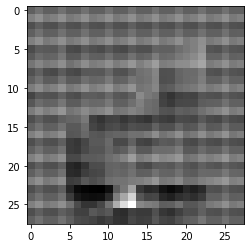

Train Epoch: 4 [0/57000 (0%)]	Loss: -0.159961
Train Epoch: 4 [2560/57000 (4%)]	Loss: -0.160898
Train Epoch: 4 [5120/57000 (9%)]	Loss: -0.162801
Train Epoch: 4 [7680/57000 (13%)]	Loss: -0.162374
Train Epoch: 4 [10240/57000 (18%)]	Loss: -0.162096
Train Epoch: 4 [12800/57000 (22%)]	Loss: -0.163423
Train Epoch: 4 [15360/57000 (27%)]	Loss: -0.158934
Train Epoch: 4 [17920/57000 (31%)]	Loss: -0.164496
Train Epoch: 4 [20480/57000 (36%)]	Loss: -0.161191
Train Epoch: 4 [23040/57000 (40%)]	Loss: -0.164398
Train Epoch: 4 [25600/57000 (45%)]	Loss: -0.162304
Train Epoch: 4 [28160/57000 (49%)]	Loss: -0.162655
Train Epoch: 4 [30720/57000 (54%)]	Loss: -0.161503
Train Epoch: 4 [33280/57000 (58%)]	Loss: -0.162429
Train Epoch: 4 [35840/57000 (63%)]	Loss: -0.162350
Train Epoch: 4 [38400/57000 (67%)]	Loss: -0.161538
Train Epoch: 4 [40960/57000 (72%)]	Loss: -0.165813
Train Epoch: 4 [43520/57000 (76%)]	Loss: -0.164820
Train Epoch: 4 [46080/57000 (81%)]	Loss: -0.163982
Train Epoch: 4 [48640/57000 (85%)]	Loss: 

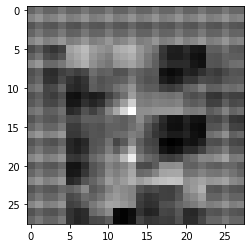

Train Epoch: 5 [0/57000 (0%)]	Loss: -0.161930
Train Epoch: 5 [2560/57000 (4%)]	Loss: -0.162500
Train Epoch: 5 [5120/57000 (9%)]	Loss: -0.164682
Train Epoch: 5 [7680/57000 (13%)]	Loss: -0.161494
Train Epoch: 5 [10240/57000 (18%)]	Loss: -0.161396
Train Epoch: 5 [12800/57000 (22%)]	Loss: -0.162231
Train Epoch: 5 [15360/57000 (27%)]	Loss: -0.161781
Train Epoch: 5 [17920/57000 (31%)]	Loss: -0.161708
Train Epoch: 5 [20480/57000 (36%)]	Loss: -0.159129
Train Epoch: 5 [23040/57000 (40%)]	Loss: -0.162954
Train Epoch: 5 [25600/57000 (45%)]	Loss: -0.161348
Train Epoch: 5 [28160/57000 (49%)]	Loss: -0.161939
Train Epoch: 5 [30720/57000 (54%)]	Loss: -0.161533
Train Epoch: 5 [33280/57000 (58%)]	Loss: -0.162629
Train Epoch: 5 [35840/57000 (63%)]	Loss: -0.162064
Train Epoch: 5 [38400/57000 (67%)]	Loss: -0.162319
Train Epoch: 5 [40960/57000 (72%)]	Loss: -0.160807
Train Epoch: 5 [43520/57000 (76%)]	Loss: -0.160505
Train Epoch: 5 [46080/57000 (81%)]	Loss: -0.160235
Train Epoch: 5 [48640/57000 (85%)]	Loss: 

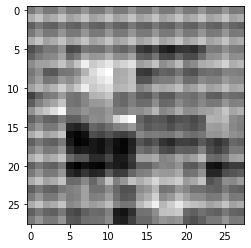

Train Epoch: 6 [0/57000 (0%)]	Loss: -0.156132
Train Epoch: 6 [2560/57000 (4%)]	Loss: -0.157673
Train Epoch: 6 [5120/57000 (9%)]	Loss: -0.160067
Train Epoch: 6 [7680/57000 (13%)]	Loss: -0.156708
Train Epoch: 6 [10240/57000 (18%)]	Loss: -0.160110
Train Epoch: 6 [12800/57000 (22%)]	Loss: -0.159663
Train Epoch: 6 [15360/57000 (27%)]	Loss: -0.159575
Train Epoch: 6 [17920/57000 (31%)]	Loss: -0.157917
Train Epoch: 6 [20480/57000 (36%)]	Loss: -0.157739
Train Epoch: 6 [23040/57000 (40%)]	Loss: -0.158510
Train Epoch: 6 [25600/57000 (45%)]	Loss: -0.157988
Train Epoch: 6 [28160/57000 (49%)]	Loss: -0.159745
Train Epoch: 6 [30720/57000 (54%)]	Loss: -0.158151
Train Epoch: 6 [33280/57000 (58%)]	Loss: -0.156529
Train Epoch: 6 [35840/57000 (63%)]	Loss: -0.157059
Train Epoch: 6 [38400/57000 (67%)]	Loss: -0.156985
Train Epoch: 6 [40960/57000 (72%)]	Loss: -0.160919
Train Epoch: 6 [43520/57000 (76%)]	Loss: -0.157909
Train Epoch: 6 [46080/57000 (81%)]	Loss: -0.156605
Train Epoch: 6 [48640/57000 (85%)]	Loss: 

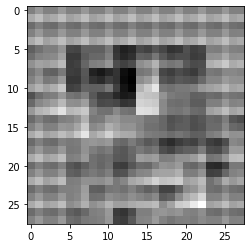

Train Epoch: 7 [0/57000 (0%)]	Loss: -0.155639
Train Epoch: 7 [2560/57000 (4%)]	Loss: -0.155846
Train Epoch: 7 [5120/57000 (9%)]	Loss: -0.156467
Train Epoch: 7 [7680/57000 (13%)]	Loss: -0.159181
Train Epoch: 7 [10240/57000 (18%)]	Loss: -0.156966
Train Epoch: 7 [12800/57000 (22%)]	Loss: -0.157202
Train Epoch: 7 [15360/57000 (27%)]	Loss: -0.155183
Train Epoch: 7 [17920/57000 (31%)]	Loss: -0.156309
Train Epoch: 7 [20480/57000 (36%)]	Loss: -0.159807
Train Epoch: 7 [23040/57000 (40%)]	Loss: -0.156141
Train Epoch: 7 [25600/57000 (45%)]	Loss: -0.155789
Train Epoch: 7 [28160/57000 (49%)]	Loss: -0.156267
Train Epoch: 7 [30720/57000 (54%)]	Loss: -0.155687
Train Epoch: 7 [33280/57000 (58%)]	Loss: -0.155250
Train Epoch: 7 [35840/57000 (63%)]	Loss: -0.155800
Train Epoch: 7 [38400/57000 (67%)]	Loss: -0.152265
Train Epoch: 7 [40960/57000 (72%)]	Loss: -0.156615
Train Epoch: 7 [43520/57000 (76%)]	Loss: -0.155784
Train Epoch: 7 [46080/57000 (81%)]	Loss: -0.156042
Train Epoch: 7 [48640/57000 (85%)]	Loss: 

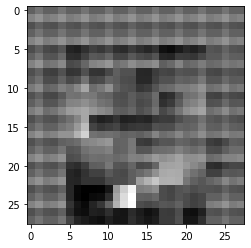

Train Epoch: 8 [0/57000 (0%)]	Loss: -0.156126
Train Epoch: 8 [2560/57000 (4%)]	Loss: -0.154657
Train Epoch: 8 [5120/57000 (9%)]	Loss: -0.154983
Train Epoch: 8 [7680/57000 (13%)]	Loss: -0.152161
Train Epoch: 8 [10240/57000 (18%)]	Loss: -0.155252
Train Epoch: 8 [12800/57000 (22%)]	Loss: -0.156118
Train Epoch: 8 [15360/57000 (27%)]	Loss: -0.153971
Train Epoch: 8 [17920/57000 (31%)]	Loss: -0.152484
Train Epoch: 8 [20480/57000 (36%)]	Loss: -0.152744
Train Epoch: 8 [23040/57000 (40%)]	Loss: -0.151583
Train Epoch: 8 [25600/57000 (45%)]	Loss: -0.154634
Train Epoch: 8 [28160/57000 (49%)]	Loss: -0.155668
Train Epoch: 8 [30720/57000 (54%)]	Loss: -0.151152
Train Epoch: 8 [33280/57000 (58%)]	Loss: -0.154503
Train Epoch: 8 [35840/57000 (63%)]	Loss: -0.154090
Train Epoch: 8 [38400/57000 (67%)]	Loss: -0.153941
Train Epoch: 8 [40960/57000 (72%)]	Loss: -0.152178
Train Epoch: 8 [43520/57000 (76%)]	Loss: -0.152304
Train Epoch: 8 [46080/57000 (81%)]	Loss: -0.154906
Train Epoch: 8 [48640/57000 (85%)]	Loss: 

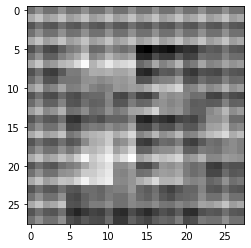

Train Epoch: 9 [0/57000 (0%)]	Loss: -0.151849
Train Epoch: 9 [2560/57000 (4%)]	Loss: -0.152062
Train Epoch: 9 [5120/57000 (9%)]	Loss: -0.150986
Train Epoch: 9 [7680/57000 (13%)]	Loss: -0.153137
Train Epoch: 9 [10240/57000 (18%)]	Loss: -0.154471
Train Epoch: 9 [12800/57000 (22%)]	Loss: -0.152058
Train Epoch: 9 [15360/57000 (27%)]	Loss: -0.152948
Train Epoch: 9 [17920/57000 (31%)]	Loss: -0.149739
Train Epoch: 9 [20480/57000 (36%)]	Loss: -0.151874
Train Epoch: 9 [23040/57000 (40%)]	Loss: -0.154084
Train Epoch: 9 [25600/57000 (45%)]	Loss: -0.153308
Train Epoch: 9 [28160/57000 (49%)]	Loss: -0.151790
Train Epoch: 9 [30720/57000 (54%)]	Loss: -0.153178
Train Epoch: 9 [33280/57000 (58%)]	Loss: -0.153230
Train Epoch: 9 [35840/57000 (63%)]	Loss: -0.152419
Train Epoch: 9 [38400/57000 (67%)]	Loss: -0.153190
Train Epoch: 9 [40960/57000 (72%)]	Loss: -0.151515
Train Epoch: 9 [43520/57000 (76%)]	Loss: -0.154037
Train Epoch: 9 [46080/57000 (81%)]	Loss: -0.151672
Train Epoch: 9 [48640/57000 (85%)]	Loss: 

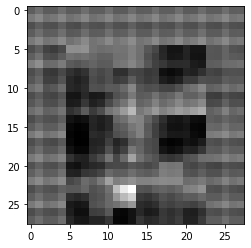

Train Epoch: 10 [0/57000 (0%)]	Loss: -0.147293
Train Epoch: 10 [2560/57000 (4%)]	Loss: -0.150656
Train Epoch: 10 [5120/57000 (9%)]	Loss: -0.149618
Train Epoch: 10 [7680/57000 (13%)]	Loss: -0.152008
Train Epoch: 10 [10240/57000 (18%)]	Loss: -0.151332
Train Epoch: 10 [12800/57000 (22%)]	Loss: -0.151009
Train Epoch: 10 [15360/57000 (27%)]	Loss: -0.149428
Train Epoch: 10 [17920/57000 (31%)]	Loss: -0.151665
Train Epoch: 10 [20480/57000 (36%)]	Loss: -0.152019
Train Epoch: 10 [23040/57000 (40%)]	Loss: -0.152041
Train Epoch: 10 [25600/57000 (45%)]	Loss: -0.152412
Train Epoch: 10 [28160/57000 (49%)]	Loss: -0.151658
Train Epoch: 10 [30720/57000 (54%)]	Loss: -0.150309
Train Epoch: 10 [33280/57000 (58%)]	Loss: -0.151593
Train Epoch: 10 [35840/57000 (63%)]	Loss: -0.155090
Train Epoch: 10 [38400/57000 (67%)]	Loss: -0.150462
Train Epoch: 10 [40960/57000 (72%)]	Loss: -0.150938
Train Epoch: 10 [43520/57000 (76%)]	Loss: -0.154494
Train Epoch: 10 [46080/57000 (81%)]	Loss: -0.151443
Train Epoch: 10 [48640

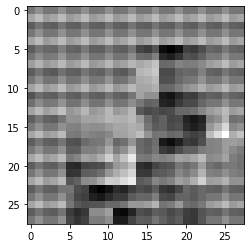

Train Epoch: 11 [0/57000 (0%)]	Loss: -0.151220
Train Epoch: 11 [2560/57000 (4%)]	Loss: -0.150657
Train Epoch: 11 [5120/57000 (9%)]	Loss: -0.151854
Train Epoch: 11 [7680/57000 (13%)]	Loss: -0.151332
Train Epoch: 11 [10240/57000 (18%)]	Loss: -0.154985
Train Epoch: 11 [12800/57000 (22%)]	Loss: -0.150426
Train Epoch: 11 [15360/57000 (27%)]	Loss: -0.153008
Train Epoch: 11 [17920/57000 (31%)]	Loss: -0.152215
Train Epoch: 11 [20480/57000 (36%)]	Loss: -0.150696
Train Epoch: 11 [23040/57000 (40%)]	Loss: -0.148145
Train Epoch: 11 [25600/57000 (45%)]	Loss: -0.149247
Train Epoch: 11 [28160/57000 (49%)]	Loss: -0.153048
Train Epoch: 11 [30720/57000 (54%)]	Loss: -0.153015
Train Epoch: 11 [33280/57000 (58%)]	Loss: -0.150903
Train Epoch: 11 [35840/57000 (63%)]	Loss: -0.151691
Train Epoch: 11 [38400/57000 (67%)]	Loss: -0.152754
Train Epoch: 11 [40960/57000 (72%)]	Loss: -0.152716
Train Epoch: 11 [43520/57000 (76%)]	Loss: -0.151778
Train Epoch: 11 [46080/57000 (81%)]	Loss: -0.153456
Train Epoch: 11 [48640

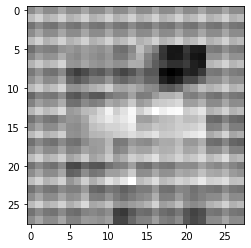

Train Epoch: 12 [0/57000 (0%)]	Loss: -0.154978
Train Epoch: 12 [2560/57000 (4%)]	Loss: -0.154128
Train Epoch: 12 [5120/57000 (9%)]	Loss: -0.152590
Train Epoch: 12 [7680/57000 (13%)]	Loss: -0.154450
Train Epoch: 12 [10240/57000 (18%)]	Loss: -0.152780
Train Epoch: 12 [12800/57000 (22%)]	Loss: -0.154685
Train Epoch: 12 [15360/57000 (27%)]	Loss: -0.154487
Train Epoch: 12 [17920/57000 (31%)]	Loss: -0.152075
Train Epoch: 12 [20480/57000 (36%)]	Loss: -0.153573
Train Epoch: 12 [23040/57000 (40%)]	Loss: -0.152920
Train Epoch: 12 [25600/57000 (45%)]	Loss: -0.152536
Train Epoch: 12 [28160/57000 (49%)]	Loss: -0.153190
Train Epoch: 12 [30720/57000 (54%)]	Loss: -0.154641
Train Epoch: 12 [33280/57000 (58%)]	Loss: -0.154471
Train Epoch: 12 [35840/57000 (63%)]	Loss: -0.151510
Train Epoch: 12 [38400/57000 (67%)]	Loss: -0.152573
Train Epoch: 12 [40960/57000 (72%)]	Loss: -0.151554
Train Epoch: 12 [43520/57000 (76%)]	Loss: -0.156460
Train Epoch: 12 [46080/57000 (81%)]	Loss: -0.154762
Train Epoch: 12 [48640

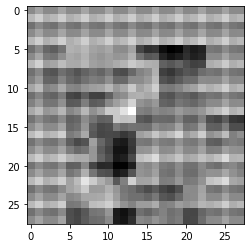

Train Epoch: 13 [0/57000 (0%)]	Loss: -0.150833
Train Epoch: 13 [2560/57000 (4%)]	Loss: -0.153225
Train Epoch: 13 [5120/57000 (9%)]	Loss: -0.154595
Train Epoch: 13 [7680/57000 (13%)]	Loss: -0.152798
Train Epoch: 13 [10240/57000 (18%)]	Loss: -0.153026
Train Epoch: 13 [12800/57000 (22%)]	Loss: -0.154139
Train Epoch: 13 [15360/57000 (27%)]	Loss: -0.151718
Train Epoch: 13 [17920/57000 (31%)]	Loss: -0.150268
Train Epoch: 13 [20480/57000 (36%)]	Loss: -0.153754
Train Epoch: 13 [23040/57000 (40%)]	Loss: -0.154377
Train Epoch: 13 [25600/57000 (45%)]	Loss: -0.151756
Train Epoch: 13 [28160/57000 (49%)]	Loss: -0.153442
Train Epoch: 13 [30720/57000 (54%)]	Loss: -0.152898
Train Epoch: 13 [33280/57000 (58%)]	Loss: -0.154875
Train Epoch: 13 [35840/57000 (63%)]	Loss: -0.152971
Train Epoch: 13 [38400/57000 (67%)]	Loss: -0.152394
Train Epoch: 13 [40960/57000 (72%)]	Loss: -0.155413
Train Epoch: 13 [43520/57000 (76%)]	Loss: -0.153442
Train Epoch: 13 [46080/57000 (81%)]	Loss: -0.155814
Train Epoch: 13 [48640

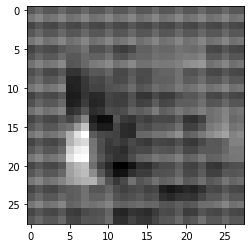

Train Epoch: 14 [0/57000 (0%)]	Loss: -0.155558
Train Epoch: 14 [2560/57000 (4%)]	Loss: -0.155634
Train Epoch: 14 [5120/57000 (9%)]	Loss: -0.153585
Train Epoch: 14 [7680/57000 (13%)]	Loss: -0.154154
Train Epoch: 14 [10240/57000 (18%)]	Loss: -0.153076
Train Epoch: 14 [12800/57000 (22%)]	Loss: -0.152751
Train Epoch: 14 [15360/57000 (27%)]	Loss: -0.153315
Train Epoch: 14 [17920/57000 (31%)]	Loss: -0.155404
Train Epoch: 14 [20480/57000 (36%)]	Loss: -0.155267
Train Epoch: 14 [23040/57000 (40%)]	Loss: -0.156242
Train Epoch: 14 [25600/57000 (45%)]	Loss: -0.155198
Train Epoch: 14 [28160/57000 (49%)]	Loss: -0.153510
Train Epoch: 14 [30720/57000 (54%)]	Loss: -0.150924
Train Epoch: 14 [33280/57000 (58%)]	Loss: -0.154621
Train Epoch: 14 [35840/57000 (63%)]	Loss: -0.152700
Train Epoch: 14 [38400/57000 (67%)]	Loss: -0.152140
Train Epoch: 14 [40960/57000 (72%)]	Loss: -0.151574
Train Epoch: 14 [43520/57000 (76%)]	Loss: -0.153623
Train Epoch: 14 [46080/57000 (81%)]	Loss: -0.153357
Train Epoch: 14 [48640

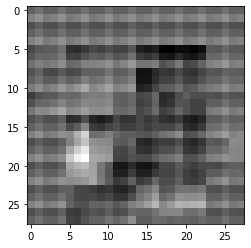

Train Epoch: 15 [0/57000 (0%)]	Loss: -0.151147
Train Epoch: 15 [2560/57000 (4%)]	Loss: -0.154856
Train Epoch: 15 [5120/57000 (9%)]	Loss: -0.154038
Train Epoch: 15 [7680/57000 (13%)]	Loss: -0.151551
Train Epoch: 15 [10240/57000 (18%)]	Loss: -0.149173
Train Epoch: 15 [12800/57000 (22%)]	Loss: -0.151825
Train Epoch: 15 [15360/57000 (27%)]	Loss: -0.153274
Train Epoch: 15 [17920/57000 (31%)]	Loss: -0.154498
Train Epoch: 15 [20480/57000 (36%)]	Loss: -0.151776
Train Epoch: 15 [23040/57000 (40%)]	Loss: -0.154432
Train Epoch: 15 [25600/57000 (45%)]	Loss: -0.154040
Train Epoch: 15 [28160/57000 (49%)]	Loss: -0.155701
Train Epoch: 15 [30720/57000 (54%)]	Loss: -0.152897
Train Epoch: 15 [33280/57000 (58%)]	Loss: -0.150517
Train Epoch: 15 [35840/57000 (63%)]	Loss: -0.151452
Train Epoch: 15 [38400/57000 (67%)]	Loss: -0.156531
Train Epoch: 15 [40960/57000 (72%)]	Loss: -0.153162
Train Epoch: 15 [43520/57000 (76%)]	Loss: -0.154896
Train Epoch: 15 [46080/57000 (81%)]	Loss: -0.151237
Train Epoch: 15 [48640

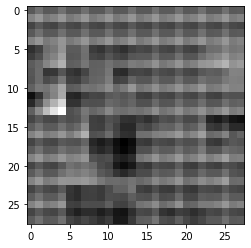

Train Epoch: 16 [0/57000 (0%)]	Loss: -0.154250
Train Epoch: 16 [2560/57000 (4%)]	Loss: -0.155247
Train Epoch: 16 [5120/57000 (9%)]	Loss: -0.156304
Train Epoch: 16 [7680/57000 (13%)]	Loss: -0.154646
Train Epoch: 16 [10240/57000 (18%)]	Loss: -0.154380
Train Epoch: 16 [12800/57000 (22%)]	Loss: -0.155440
Train Epoch: 16 [15360/57000 (27%)]	Loss: -0.156448
Train Epoch: 16 [17920/57000 (31%)]	Loss: -0.155853
Train Epoch: 16 [20480/57000 (36%)]	Loss: -0.152357
Train Epoch: 16 [23040/57000 (40%)]	Loss: -0.152996
Train Epoch: 16 [25600/57000 (45%)]	Loss: -0.154278
Train Epoch: 16 [28160/57000 (49%)]	Loss: -0.157053
Train Epoch: 16 [30720/57000 (54%)]	Loss: -0.154324
Train Epoch: 16 [33280/57000 (58%)]	Loss: -0.153098
Train Epoch: 16 [35840/57000 (63%)]	Loss: -0.155132
Train Epoch: 16 [38400/57000 (67%)]	Loss: -0.153599
Train Epoch: 16 [40960/57000 (72%)]	Loss: -0.156006
Train Epoch: 16 [43520/57000 (76%)]	Loss: -0.152784
Train Epoch: 16 [46080/57000 (81%)]	Loss: -0.154113
Train Epoch: 16 [48640

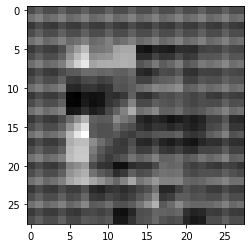

Train Epoch: 17 [0/57000 (0%)]	Loss: -0.156993
Train Epoch: 17 [2560/57000 (4%)]	Loss: -0.154273
Train Epoch: 17 [5120/57000 (9%)]	Loss: -0.156129
Train Epoch: 17 [7680/57000 (13%)]	Loss: -0.154699
Train Epoch: 17 [10240/57000 (18%)]	Loss: -0.153512
Train Epoch: 17 [12800/57000 (22%)]	Loss: -0.152808
Train Epoch: 17 [15360/57000 (27%)]	Loss: -0.153890
Train Epoch: 17 [17920/57000 (31%)]	Loss: -0.154862
Train Epoch: 17 [20480/57000 (36%)]	Loss: -0.155661
Train Epoch: 17 [23040/57000 (40%)]	Loss: -0.155726
Train Epoch: 17 [25600/57000 (45%)]	Loss: -0.148612
Train Epoch: 17 [28160/57000 (49%)]	Loss: -0.150958
Train Epoch: 17 [30720/57000 (54%)]	Loss: -0.154293
Train Epoch: 17 [33280/57000 (58%)]	Loss: -0.157981
Train Epoch: 17 [35840/57000 (63%)]	Loss: -0.153800
Train Epoch: 17 [38400/57000 (67%)]	Loss: -0.152621
Train Epoch: 17 [40960/57000 (72%)]	Loss: -0.156465
Train Epoch: 17 [43520/57000 (76%)]	Loss: -0.153575
Train Epoch: 17 [46080/57000 (81%)]	Loss: -0.153111
Train Epoch: 17 [48640

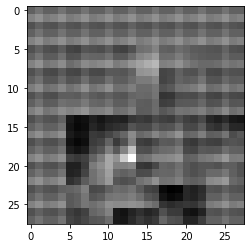

Train Epoch: 18 [0/57000 (0%)]	Loss: -0.150739
Train Epoch: 18 [2560/57000 (4%)]	Loss: -0.150769
Train Epoch: 18 [5120/57000 (9%)]	Loss: -0.153928
Train Epoch: 18 [7680/57000 (13%)]	Loss: -0.155040
Train Epoch: 18 [10240/57000 (18%)]	Loss: -0.151898
Train Epoch: 18 [12800/57000 (22%)]	Loss: -0.157043
Train Epoch: 18 [15360/57000 (27%)]	Loss: -0.152369
Train Epoch: 18 [17920/57000 (31%)]	Loss: -0.153463
Train Epoch: 18 [20480/57000 (36%)]	Loss: -0.154988
Train Epoch: 18 [23040/57000 (40%)]	Loss: -0.155993
Train Epoch: 18 [25600/57000 (45%)]	Loss: -0.152828
Train Epoch: 18 [28160/57000 (49%)]	Loss: -0.153499
Train Epoch: 18 [30720/57000 (54%)]	Loss: -0.155349
Train Epoch: 18 [33280/57000 (58%)]	Loss: -0.153400
Train Epoch: 18 [35840/57000 (63%)]	Loss: -0.154529
Train Epoch: 18 [38400/57000 (67%)]	Loss: -0.153691
Train Epoch: 18 [40960/57000 (72%)]	Loss: -0.154666
Train Epoch: 18 [43520/57000 (76%)]	Loss: -0.153468
Train Epoch: 18 [46080/57000 (81%)]	Loss: -0.154205
Train Epoch: 18 [48640

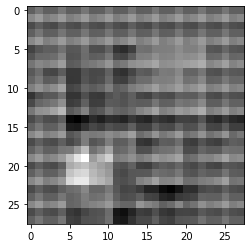

Train Epoch: 19 [0/57000 (0%)]	Loss: -0.151733
Train Epoch: 19 [2560/57000 (4%)]	Loss: -0.154070
Train Epoch: 19 [5120/57000 (9%)]	Loss: -0.153510
Train Epoch: 19 [7680/57000 (13%)]	Loss: -0.151239
Train Epoch: 19 [10240/57000 (18%)]	Loss: -0.151168
Train Epoch: 19 [12800/57000 (22%)]	Loss: -0.153028
Train Epoch: 19 [15360/57000 (27%)]	Loss: -0.155617
Train Epoch: 19 [17920/57000 (31%)]	Loss: -0.151105
Train Epoch: 19 [20480/57000 (36%)]	Loss: -0.153190
Train Epoch: 19 [23040/57000 (40%)]	Loss: -0.149669
Train Epoch: 19 [25600/57000 (45%)]	Loss: -0.149660
Train Epoch: 19 [28160/57000 (49%)]	Loss: -0.155334
Train Epoch: 19 [30720/57000 (54%)]	Loss: -0.150468
Train Epoch: 19 [33280/57000 (58%)]	Loss: -0.152280
Train Epoch: 19 [35840/57000 (63%)]	Loss: -0.156774
Train Epoch: 19 [38400/57000 (67%)]	Loss: -0.151991
Train Epoch: 19 [40960/57000 (72%)]	Loss: -0.152009
Train Epoch: 19 [43520/57000 (76%)]	Loss: -0.152101
Train Epoch: 19 [46080/57000 (81%)]	Loss: -0.156123
Train Epoch: 19 [48640

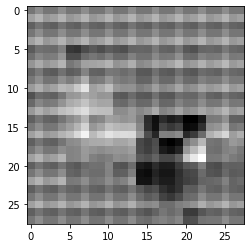

Train Epoch: 20 [0/57000 (0%)]	Loss: -0.155419
Train Epoch: 20 [2560/57000 (4%)]	Loss: -0.155953
Train Epoch: 20 [5120/57000 (9%)]	Loss: -0.152301
Train Epoch: 20 [7680/57000 (13%)]	Loss: -0.152333
Train Epoch: 20 [10240/57000 (18%)]	Loss: -0.154497
Train Epoch: 20 [12800/57000 (22%)]	Loss: -0.152526
Train Epoch: 20 [15360/57000 (27%)]	Loss: -0.150289
Train Epoch: 20 [17920/57000 (31%)]	Loss: -0.152802
Train Epoch: 20 [20480/57000 (36%)]	Loss: -0.156572
Train Epoch: 20 [23040/57000 (40%)]	Loss: -0.154195
Train Epoch: 20 [25600/57000 (45%)]	Loss: -0.153338
Train Epoch: 20 [28160/57000 (49%)]	Loss: -0.156531
Train Epoch: 20 [30720/57000 (54%)]	Loss: -0.155068
Train Epoch: 20 [33280/57000 (58%)]	Loss: -0.155341
Train Epoch: 20 [35840/57000 (63%)]	Loss: -0.155089
Train Epoch: 20 [38400/57000 (67%)]	Loss: -0.154914
Train Epoch: 20 [40960/57000 (72%)]	Loss: -0.155868
Train Epoch: 20 [43520/57000 (76%)]	Loss: -0.156107
Train Epoch: 20 [46080/57000 (81%)]	Loss: -0.155206
Train Epoch: 20 [48640

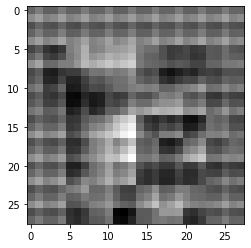

In [0]:
bottleneck = 512
vae = VAE(bottleneck).cuda()
optimizer = torch.optim.Adam(vae.parameters(), lr=hparams['learning_rate'], weight_decay=1e-5)

for epoch in range(1, hparams['num_epochs'] + 1):
    train_VAE(vae, train_loader, optimizer, hparams, epoch)
    # test(vae, test_loader, hparams)

    sample = Variable(torch.randn(64, bottleneck)).cuda()
    sample = model.decoder(sample).detach().cpu().numpy()
    plt.imshow(sample[0][0], cmap='gray')
    plt.show()
    